# DATASCI 347: Machine Learning (Fall 2025)
## Logistic Regression/Classification

## Upload Dataset to Google Colab

Since we are working in Google Colab, we must first upload the dataset file (`Framingham.dat`).
Run the following cell and choose the file from your local computer.
python

In [1]:
from google.colab import files  # import Colab's file upload tool
uploaded = files.upload()  # open a file chooser to upload local files

# After uploading, the dataset can be read normally with pandas:
# fram_data = pd.read_csv("Framingham.dat")

Saving FRAMINGHAM.dat to FRAMINGHAM.dat


When this cell is executed, Colab will open a dialog box for selecting files from your computer.
After upload, the file is stored in Colab's working directory, and it can be loaded using `pd.read_csv("Framingham.dat")`.

## Objectives

What are possible risk factors related to heart diseases? What determines an employee being a desirable one with the firm? How to tell a review in Amazon is real or fake? How to model a categorical variables conveniently and efficiently? Logistic regression models are most commonly used methods to model the probability of an event. We then automatically get a linear classification rules. Various criteria are introduced. Analogous to least squared solutions for the usual regression models, we use maximum likelihood estimations.

### Introduction
- A quick EDA
- Logistic Regressions (Illustrated with one predictor)
- Link Function
- Maximum Likelihood Estimator (MLE)
- Min cross entropy
- Inference for the Coefficients
- Wald Intervals / Tests (through the MLE's)
- Likelihood Ratio Intervals / Tests (Chi-Squared Tests)

### Classification
- Classification rules: thresholding $p(y=1|x)$
- Criteria
  - Sensitivity
  - Specificity (False Positive)
  - Misclassification errors
  - ROC (Receiver Operating Characteristic) curves and AUC (Area Under the Curve)
  - FDR

### Multiple Logistic Regressions
- Natural Extension
- Model selection through backward selection or AIC (Akaike's Information Criterion)
- Final model
- Classification
- Bayes rules
- Unequal costs
- Weighted misclassification error
- Training/Testing/Validation data

## 1. Case Study: Framingham Heart Study

Heart disease is the leading cause of death in United States. One out of four deaths is due to heart disease. It is important to identify Coronary Heart Disease risk factors. Many studies have indicated high blood pressure, high cholesterol, age, gender, race are among some major risk factors.

Starting from late 1940s, National Heart, Lung and Blood Institute (NHLBI) launched its famous Framingham Heart Study. By now subjects of three generations together with other people have been monitored and followed in the study. Over thousands of research papers have been published using these longitudinal data sets.

Using a piece of the data gathered at the beginning of the study, we illustrate how to identify risk factors of heart disease and how to classify one with a heart disease.

### i) Data: 1,406 participants. Conditions gathered at the beginning of the study (early 1950s).

| Variable | Description |
|----------|-------------|
| Heart Disease | Indicator of having heart disease or not |
| AGE | Age |
| SEX | Gender |
| SBP | Systolic blood pressure |
| DBP | Diastolic blood pressure |
| CHOL | Cholesterol level |
| FRW | Age and gender adjusted weight |
| CIG | Self-reported number of cigarettes smoked each week |

### ii) Goal:
- Identify risk factors
- Predict the probability of one with Heart Disease
- Predict if one has Heart Disease given the information in hand

In particular, predict $Prob(HD=1)$ for Alice, who is:

| AGE | SEX | SBP | DBP | CHOL | FRW | CIG |
|-----|-----|-----|-----|------|-----|-----|
| 45 | FEMALE | 100 | 80 | 180 | 110 | 5 |

where $HD = \begin{cases} 1 & \text{if heart disease} \\ 0 & \text{if normal} \end{cases}$

### 1.1 EDA

Let's load the necessary libraries and explore our dataset:

In [2]:
import pandas as pd  # pandas library for data manipulation
import numpy as np  # numpy for numerical operations
import matplotlib.pyplot as plt  # matplotlib for plotting
import seaborn as sns  # seaborn for statistical visualizations
import statsmodels.api as sm  # statsmodels for statistical models
import statsmodels.formula.api as smf  # formula API for regression
from sklearn.metrics import roc_curve, auc  # sklearn for ROC and AUC
from sklearn.metrics import confusion_matrix, classification_report  # classification metrics
from sklearn.linear_model import LogisticRegression  # logistic regression
import warnings  # to suppress warnings
warnings.filterwarnings('ignore')  # ignore warning messages

# Set visualization style
plt.style.use('seaborn-v0_8')  # use seaborn style for better-looking plots
sns.set_palette("husl")  # set color palette

This code imports all essential Python libraries for our logistic regression analysis. The `pandas` library provides DataFrames for tabular data manipulation. The `numpy` library offers numerical array operations. The `matplotlib.pyplot` and `seaborn` libraries create statistical visualizations. The `statsmodels` package provides comprehensive statistical modeling including logistic regression. The `sklearn` library offers machine learning tools for classification metrics. The `warnings.filterwarnings('ignore')` suppresses warning messages to keep output clean.

Now let's read the Framingham dataset:

In [6]:
# Read Framingham.dat
import os
print(os.listdir())
fram_data = pd.read_csv("FRAMINGHAM.dat", sep=",", header=0)  # read CSV with comma separator and header row

# Display structure and summary
print("Data structure:")  # label the output
print(fram_data.info())  # show data types and non-null counts
print("\nColumn names:")  # newline character \n creates line break
print(fram_data.columns.tolist())  # convert column names to list
print("\nData summary:")  # label summary statistics
print(fram_data.describe())  # display statistical summary

['.config', 'FRAMINGHAM.dat', 'sample_data']
Data structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407 entries, 0 to 1406
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Heart Disease?  1406 non-null   float64
 1   AGE             1407 non-null   int64  
 2   SEX             1407 non-null   object 
 3   SBP             1407 non-null   int64  
 4   DBP             1407 non-null   int64  
 5   CHOL            1407 non-null   int64  
 6   FRW             1396 non-null   float64
 7   CIG             1405 non-null   float64
dtypes: float64(3), int64(4), object(1)
memory usage: 88.1+ KB
None

Column names:
['Heart Disease?', 'AGE', 'SEX', 'SBP', 'DBP', 'CHOL', 'FRW', 'CIG']

Data summary:
       Heart Disease?          AGE          SBP          DBP         CHOL  \
count     1406.000000  1407.000000  1407.000000  1407.000000  1407.000000   
mean         0.221195    52.439943   148.093106    90.136461  

The `pd.read_csv()` function reads the CSV file into a DataFrame. The `sep=","` parameter specifies comma as the delimiter. The `header=True` indicates the first row contains column names. The `.info()` method displays the DataFrame structure including data types and non-null counts. The `.columns.tolist()` extracts column names as a Python list. The `.describe()` method provides summary statistics for numerical columns.

Let's rename columns and set correct data types:

In [8]:
# Rename the first column and convert to appropriate types
fram_data = fram_data.rename(columns={'Heart Disease?': 'HD'})  # rename using dictionary mapping
fram_data['HD'] = fram_data['HD'].astype('category')  # convert HD to categorical type
fram_data['SEX'] = fram_data['SEX'].astype('category')  # convert SEX to categorical type

# Alternative using method chaining (pandas pipe style)
# fram_data = (fram_data
#              .rename(columns={'Heart Disease?': 'HD'})  # rename column
#              .assign(HD=lambda x: x['HD'].astype('category'),  # convert HD
#                     SEX=lambda x: x['SEX'].astype('category')))  # convert SEX

The `.rename()` method changes column names using a dictionary where keys are old names and values are new names. The `.astype('category')` converts columns to categorical data type, which is memory-efficient for variables with limited unique values. The alternative shows method chaining using `.assign()` with lambda functions, which creates a more functional programming style.

Let's examine the structure of our cleaned data:

In [9]:
print("Data structure:")  # label
print(fram_data.info())  # display info
print(f"\nDataset has {fram_data.shape[0]} rows and {fram_data.shape[1]} columns")  # f-string formatting

Data structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407 entries, 0 to 1406
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   HD      1406 non-null   category
 1   AGE     1407 non-null   int64   
 2   SEX     1407 non-null   category
 3   SBP     1407 non-null   int64   
 4   DBP     1407 non-null   int64   
 5   CHOL    1407 non-null   int64   
 6   FRW     1396 non-null   float64 
 7   CIG     1405 non-null   float64 
dtypes: category(2), float64(2), int64(4)
memory usage: 69.1 KB
None

Dataset has 1407 rows and 8 columns


The `.shape` attribute returns a tuple `(rows, columns)`. The f-string `f"..."` allows embedding expressions inside strings using curly braces `{}`. The `[0]` index accesses the first element (rows), and `[1]` accesses the second element (columns).

We'll create a new row for Alice for prediction:

In [10]:
# Create Alice's data for prediction
alice_data = pd.DataFrame({  # create DataFrame from dictionary
    'HD': [np.nan],  # missing value for response variable
    'AGE': [45],  # age in list format for DataFrame
    'SEX': ['FEMALE'],  # gender as string in list
    'SBP': [100],  # systolic blood pressure
    'DBP': [80],  # diastolic blood pressure
    'CHOL': [180],  # cholesterol
    'FRW': [110],  # adjusted weight
    'CIG': [5]  # cigarettes per week
})

# Display Alice's data
print("Alice's data for prediction:")  # label
print(alice_data)  # show the data

Alice's data for prediction:
   HD  AGE     SEX  SBP  DBP  CHOL  FRW  CIG
0 NaN   45  FEMALE  100   80   180  110    5


The `pd.DataFrame()` creates a DataFrame from a dictionary. Each key becomes a column name, and values must be lists (even for single values) to create proper DataFrame structure. The `np.nan` represents a missing value for the response variable HD since we want to predict it.

Let's separate Alice's data from the training data:

In [11]:
# Append Alice to the main dataset temporarily
fram_data_with_alice = pd.concat([fram_data, alice_data], ignore_index=True)  # concatenate DataFrames

# Save Alice's data separately
fram_data_new = fram_data_with_alice.iloc[[-1]]  # select last row as DataFrame using double brackets

# Remove Alice from training data
fram_data = fram_data_with_alice.iloc[:-1]  # select all rows except last using slice notation

print(f"Training data shape: {fram_data.shape}")  # display dimensions
print(f"Alice's data shape: {fram_data_new.shape}")  # display dimensions

Training data shape: (1407, 8)
Alice's data shape: (1, 8)


The `pd.concat()` function concatenates DataFrames vertically (stacking rows). The `ignore_index=True` resets row indices to sequential numbers. The `.iloc[[-1]]` selects the last row, where double brackets `[[]]` ensure we get a DataFrame (not a Series). The `.iloc[:-1]` uses slice notation to select all rows except the last one.

Let's examine the distribution of heart disease in our data:

In [13]:
# Summary statistics
print("Summary of the data:")  # label
print(fram_data.describe(include='all'))  # include='all' shows stats for all column types

# Count of HD values
hd_counts = fram_data['HD'].value_counts()  # count occurrences of each category
print(f"\nHeart Disease distribution:")  # label with newline
print(f"HD = 0 (Normal): {hd_counts[0.0]} observations")  # access count for category 0.0
print(f"HD = 1 (Disease): {hd_counts[1.0]} observations")  # access count for category 1.0

Summary of the data:
            HD          AGE     SEX          SBP          DBP         CHOL  \
count   1406.0  1407.000000    1407  1407.000000  1407.000000  1407.000000   
unique     2.0          NaN       2          NaN          NaN          NaN   
top        0.0          NaN  FEMALE          NaN          NaN          NaN   
freq    1095.0          NaN     738          NaN          NaN          NaN   
mean       NaN    52.439943     NaN   148.093106    90.136461   234.662402   
std        NaN     4.787124     NaN    28.047217    14.205157    46.296978   
min        NaN    45.000000     NaN    90.000000    50.000000    96.000000   
25%        NaN    48.000000     NaN   130.000000    80.000000   200.000000   
50%        NaN    52.000000     NaN   142.000000    90.000000   230.000000   
75%        NaN    56.000000     NaN   160.000000    98.000000   264.000000   
max        NaN    62.000000     NaN   300.000000   160.000000   430.000000   

                FRW          CIG  
count  

The `.describe(include='all')` parameter includes both numerical and categorical variables in the summary. The `.value_counts()` method counts occurrences of each unique value in a Series. We access specific counts using square bracket notation with the category label.

Check for missing values:

In [14]:
missing_counts = fram_data.isnull().sum()  # count NaN values in each column
print("Missing values per column:")  # label
print(missing_counts[missing_counts > 0])  # show only columns with missing values
print(f"\nTotal missing values: {fram_data.isnull().sum().sum()}")  # sum of all missing values

Missing values per column:
HD      1
FRW    11
CIG     2
dtype: int64

Total missing values: 14


The `.isnull()` method returns a DataFrame of boolean values (True for missing, False otherwise). The first `.sum()` counts True values per column. The boolean indexing `[missing_counts > 0]` filters to show only columns with missing values. The double `.sum().sum()` first sums per column, then sums all columns together.

### 1.2 HD vs SBP

For simplicity, we start with a simple question: How does HD relate to SBP (Systolic Blood Pressure)?

In [15]:
# Group by HD and calculate mean SBP
grouped_stats = fram_data.groupby('HD')['SBP'].agg(['mean', 'std', 'count'])  # aggregate multiple statistics
print("SBP statistics by HD status:")  # label
print(grouped_stats)  # display statistics

SBP statistics by HD status:
           mean        std  count
HD                               
0.0  145.115982  26.275545   1095
1.0  158.729904  31.290384    311


The `.groupby('HD')` splits the data into groups based on HD values. The `['SBP']` selects the SBP column for each group. The `.agg()` method applies multiple aggregation functions specified in a list. This shows mean, standard deviation, and count of SBP for each HD category.

On average, SBP seems to be higher among HD = 1. Let's visualize this:

<Figure size 800x600 with 0 Axes>

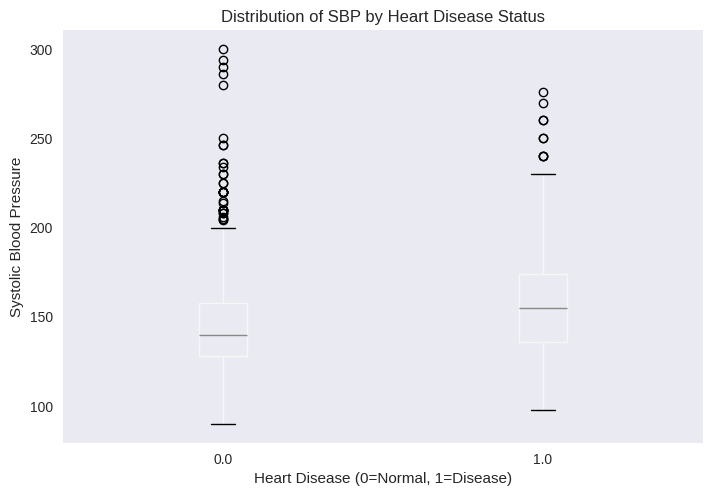

In [16]:
# Create back-to-back box plots
plt.figure(figsize=(8, 6))  # create figure 8 inches wide, 6 inches tall
fram_data.boxplot(column='SBP', by='HD', grid=False)  # boxplot of SBP grouped by HD
plt.suptitle('')  # remove automatic title
plt.title('Distribution of SBP by Heart Disease Status')  # set custom title
plt.xlabel('Heart Disease (0=Normal, 1=Disease)')  # x-axis label
plt.ylabel('Systolic Blood Pressure')  # y-axis label
plt.show()  # display the plot

The `.boxplot()` method creates box-and-whisker plots. The `column='SBP'` specifies which variable to plot, and `by='HD'` creates separate boxes for each HD category. The `grid=False` removes background grid lines. The box shows the interquartile range (25th to 75th percentile), the line inside shows the median, and whiskers extend to show the data range.

Now let's explore how proportions of HD = 1 relate to SBP:

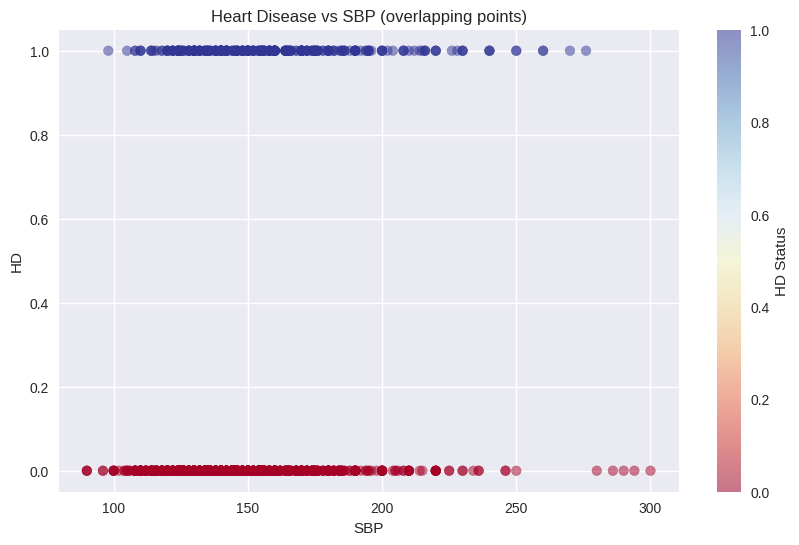

In [18]:
# Convert HD to numeric for plotting
# Drop rows with missing HD before converting to integer
fram_data_cleaned = fram_data.dropna(subset=['HD']).copy()
fram_data_cleaned['HD_numeric'] = fram_data_cleaned['HD'].astype(int)  # convert categories to integers (0, 1)

# Standard scatter plot
plt.figure(figsize=(10, 6))  # create figure
plt.scatter(fram_data_cleaned['SBP'], fram_data_cleaned['HD_numeric'],  # x and y coordinates
           c=fram_data_cleaned['HD_numeric'], cmap='RdYlBu',  # color by HD status using colormap
           alpha=0.5)  # transparency level
plt.xlabel('SBP')  # x-axis label
plt.ylabel('HD')  # y-axis label
plt.title('Heart Disease vs SBP (overlapping points)')  # title
plt.colorbar(label='HD Status')  # add color bar with label
plt.show()  # display

The `.astype(int)` converts categorical values to integers (0 becomes 0, 1 becomes 1). The `plt.scatter()` creates a scatter plot where `c=` sets point colors and `cmap='RdYlBu'` specifies a color map. The `alpha=0.5` makes points 50% transparent to see overlapping. The problem is many observations overlap, making it hard to see the true distribution.

Let's use jitter to spread out overlapping points:

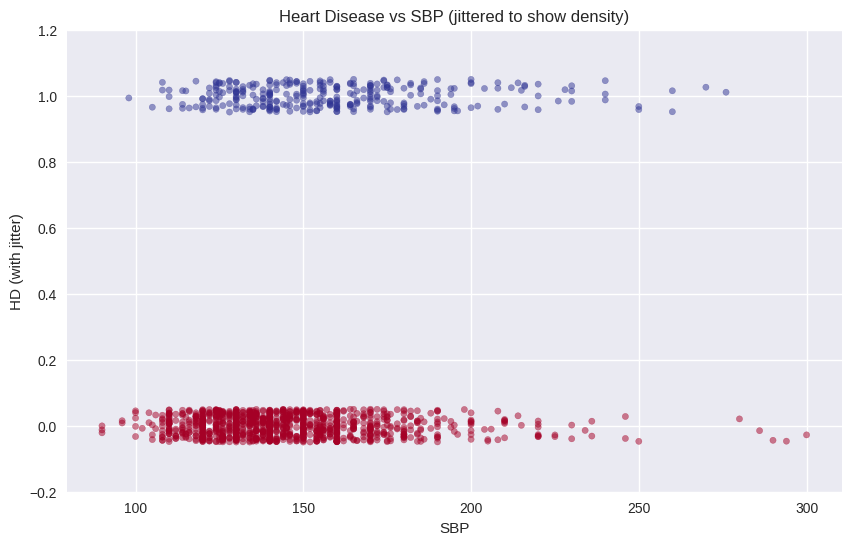

In [20]:
# Add jitter to see overlapping points
np.random.seed(42)  # set seed for reproducibility
jitter_amount = 0.05  # amount of random noise to add
jittered_y = fram_data_cleaned['HD_numeric'] + np.random.uniform(-jitter_amount, jitter_amount,  # add uniform noise
                                                         size=len(fram_data_cleaned))  # same length as data

plt.figure(figsize=(10, 6))  # create figure
plt.scatter(fram_data_cleaned['SBP'], jittered_y,  # plot with jittered y values
           c=fram_data_cleaned['HD_numeric'], cmap='RdYlBu',  # color by HD
           alpha=0.5, s=20)  # small point size s=20
plt.xlabel('SBP')  # x label
plt.ylabel('HD (with jitter)')  # y label
plt.title('Heart Disease vs SBP (jittered to show density)')  # title
plt.ylim(-0.2, 1.2)  # set y-axis limits
plt.show()  # display

The `np.random.seed(42)` ensures reproducible random numbers. The `np.random.uniform()` generates random numbers uniformly distributed between the specified bounds. The `size=` parameter ensures we get one random value per observation. Adding jitter spreads points vertically, revealing the density of observations at each SBP value.

Can we use a linear model for this binary response?

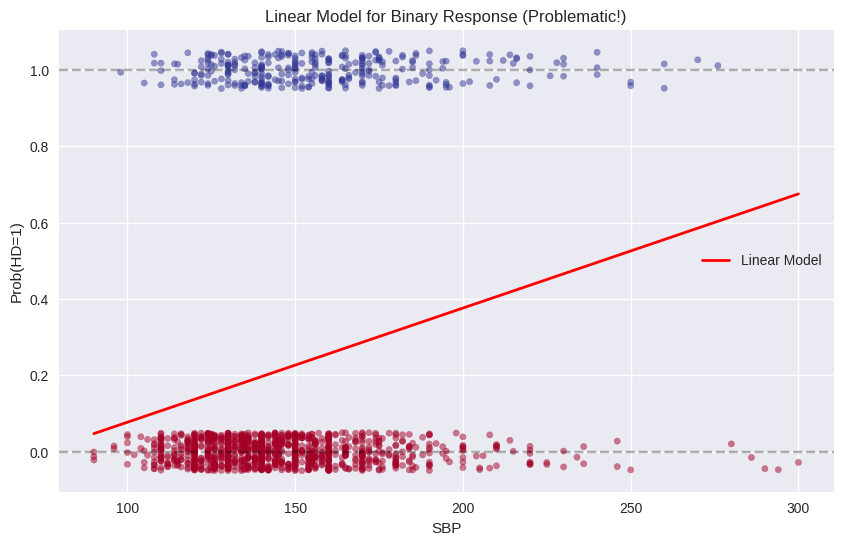

In [22]:
# Fit a linear regression (not recommended for binary outcomes!)
from sklearn.linear_model import LinearRegression  # import linear regression

X_sbp = fram_data_cleaned[['SBP']].values  # feature matrix (2D array)
y_hd = fram_data_cleaned['HD_numeric'].values  # response vector (1D array)

linear_model = LinearRegression()  # create model instance
linear_model.fit(X_sbp, y_hd)  # fit model to data

# Create predictions
sbp_range = np.linspace(fram_data_cleaned['SBP'].min(), fram_data_cleaned['SBP'].max(), 100)  # 100 evenly spaced points
linear_pred = linear_model.predict(sbp_range.reshape(-1, 1))  # predictions (reshape for 2D input)

# Plot
plt.figure(figsize=(10, 6))  # create figure
plt.scatter(fram_data_cleaned['SBP'], jittered_y, c=fram_data_cleaned['HD_numeric'],  # scatter with jitter
           cmap='RdYlBu', alpha=0.5, s=20)  # styling
plt.plot(sbp_range, linear_pred, 'r-', linewidth=2,  # red line for linear model
        label='Linear Model')  # label for legend
plt.xlabel('SBP')  # x label
plt.ylabel('Prob(HD=1)')  # y label
plt.title('Linear Model for Binary Response (Problematic!)')  # title
plt.legend()  # show legend
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)  # horizontal line at 0
plt.axhline(y=1, color='k', linestyle='--', alpha=0.3)  # horizontal line at 1
plt.show()  # display

The `.values` attribute extracts NumPy arrays from pandas Series/DataFrames. The `.reshape(-1, 1)` converts a 1D array to 2D with one column (required by sklearn). The `np.linspace()` creates evenly spaced values. The problem with linear regression for binary outcomes is that predictions can fall outside [0,1], which makes no sense for probabilities. The `plt.axhline()` adds horizontal reference lines showing the valid probability range.

## 2. Logistic Regression: HD ~ SBP

We clearly would like to model probability of one with HD given SBP. One of the most popular models is the logistic regression model.

### 2.1 Logistic Model

In logistic regression, we model the probability of HD=1 as:

$$P(HD=1|SBP) = \frac{e^{\beta_0 + \beta_1 \cdot SBP}}{1 + e^{\beta_0 + \beta_1 \cdot SBP}}$$

where $\beta_0$ and $\beta_1$ are unknown parameters. We see the following properties immediately:

$$0 < P(HD=1|SBP) = \frac{e^{\beta_0 + \beta_1 \cdot SBP}}{1 + e^{\beta_0 + \beta_1 \cdot SBP}} < 1$$

We get $P(HD=0|SBP)$:

$$P(HD=0|SBP) = 1 - P(HD=1|SBP) = \frac{1}{1 + e^{\beta_0 + \beta_1 \cdot SBP}}$$

What does the linear function describe? It is the log odds of being HD:

$$logit(P(HD=1|SBP)) = \log\left(\frac{P(HD=1|SBP)}{P(HD=0|SBP)}\right) = \beta_0 + \beta_1 \times SBP$$

The interpretation of $\beta_1$ is the change in log odds for a unit change in SBP.

$P(HD=1|SBP)$ is a monotone function of SBP, depending on the sign of $\beta_1$. $P(HD=1|SBP)$ is an increasing function of SBP if $\beta_1 > 0$.

### 2.2 Maximum Likelihood Estimators (MLE)

For categorical responses, we use Maximum Likelihood Estimation instead of least squares. Let's fit the logistic regression:

In [23]:
# Fit logistic regression using statsmodels
fit1 = smf.glm('HD ~ SBP', data=fram_data,  # formula notation: response ~ predictor
              family=sm.families.Binomial(link=sm.families.links.Logit()))  # binomial family with logit link
fit1_result = fit1.fit()  # fit the model using MLE

print("Logistic Regression Results:")  # label
print(fit1_result.summary())  # display comprehensive summary

Logistic Regression Results:
                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['HD[0.0]', 'HD[1.0]']   No. Observations:                 1406
Model:                                GLM   Df Residuals:                     1404
Model Family:                    Binomial   Df Model:                            1
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -716.41
Date:                    Wed, 22 Oct 2025   Deviance:                       1432.8
Time:                            02:19:19   Pearson chi2:                 1.40e+03
No. Iterations:                         4   Pseudo R-squ. (CS):            0.03705
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------

The `smf.glm()` creates a Generalized Linear Model. The formula `'HD ~ SBP'` specifies HD as the response and SBP as the predictor. The `family=sm.families.Binomial()` specifies binary outcomes. The `link=sm.families.links.Logit()` uses the logit link function, making this logistic regression. The `.fit()` method uses Maximum Likelihood Estimation to find optimal parameters.

The MLE maximizes the likelihood function:

$$\mathcal{L}(\beta_0, \beta_1 | Data) = \prod_{i=1}^n P(HD_i | SBP_i)$$

where the product is over all observations. For HD=1, we use $P(HD=1|SBP)$, and for HD=0, we use $P(HD=0|SBP) = 1 - P(HD=1|SBP)$.

#### 2.2.1 Prediction

Let's extract the fitted equation and make predictions:

In [24]:
# Extract coefficients
intercept = fit1_result.params['Intercept']  # beta_0 estimate
slope = fit1_result.params['SBP']  # beta_1 estimate

print(f"Fitted equation: logit = {intercept:.4f} + {slope:.4f} * SBP")  # display equation

# Predict for Alice (SBP = 100)
alice_logit = intercept + slope * 100  # calculate log odds
alice_prob = np.exp(alice_logit) / (1 + np.exp(alice_logit))  # convert to probability

print(f"\nFor Alice with SBP=100:")  # label
print(f"Log odds (logit): {alice_logit:.4f}")  # log odds
print(f"Probability of HD: {alice_prob:.4f}")  # probability

# Alternative: use predict function
alice_pred = fit1_result.predict(fram_data_new)  # predict using new data
print(f"Prediction using predict(): {alice_pred.values[0]:.4f}")  # extract value

Fitted equation: logit = 3.6634 + -0.0159 * SBP

For Alice with SBP=100:
Log odds (logit): 2.0734
Probability of HD: 0.8883
Prediction using predict(): 0.8883


The `.params` attribute contains fitted coefficients indexed by variable names. The logit (log odds) is the linear combination $\beta_0 + \beta_1 \times SBP$. To convert log odds to probability, we use the inverse logit function: $p = e^{logit} / (1 + e^{logit})$. The `.predict()` method automatically applies this transformation when predicting probabilities.

#### 2.2.2 Interpretations

Let's visualize and interpret the results:

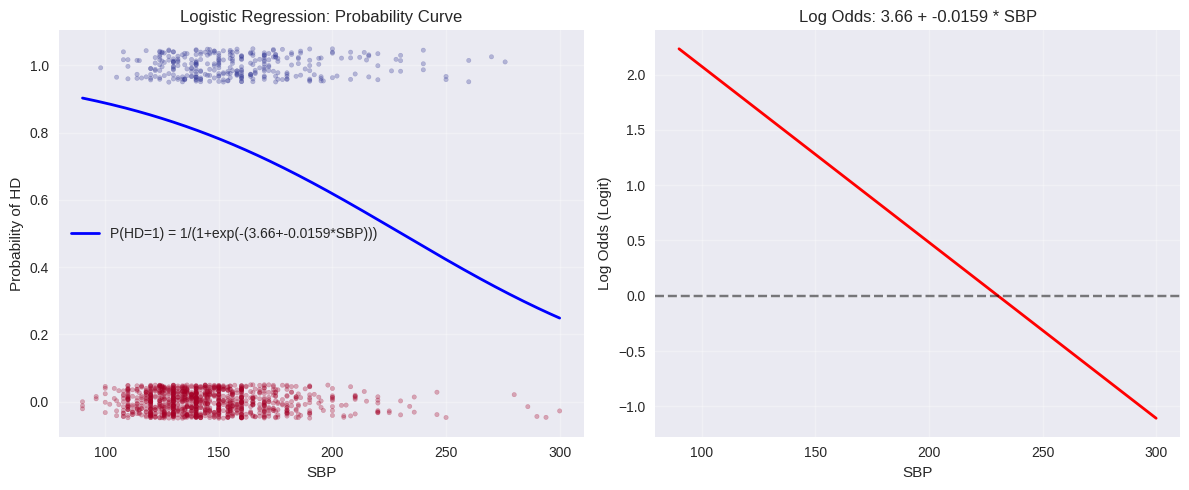

In [26]:
# Create prediction curve
sbp_range = np.linspace(90, 300, 200)  # range of SBP values
logit_values = intercept + slope * sbp_range  # calculate log odds
prob_values = 1 / (1 + np.exp(-logit_values))  # sigmoid transformation (alternative formula)

# Plot the logistic curve
plt.figure(figsize=(12, 5))  # create figure with 2 subplots

# Subplot 1: Probability curve
plt.subplot(1, 2, 1)  # first subplot in 1x2 grid
plt.scatter(fram_data_cleaned['SBP'], jittered_y,  # data points
           c=fram_data_cleaned['HD_numeric'], cmap='RdYlBu',  # coloring
           alpha=0.3, s=10)  # transparency and size
plt.plot(sbp_range, prob_values, 'b-', linewidth=2,  # logistic curve
        label=f'P(HD=1) = 1/(1+exp(-({intercept:.2f}+{slope:.4f}*SBP)))')  # equation in legend
plt.xlabel('SBP')  # x label
plt.ylabel('Probability of HD')  # y label
plt.title('Logistic Regression: Probability Curve')  # title
plt.legend()  # show legend
plt.grid(True, alpha=0.3)  # add grid

# Subplot 2: Log odds (logit)
plt.subplot(1, 2, 2)  # second subplot
plt.plot(sbp_range, logit_values, 'r-', linewidth=2)  # linear in logit scale
plt.xlabel('SBP')  # x label
plt.ylabel('Log Odds (Logit)')  # y label
plt.title(f'Log Odds: {intercept:.2f} + {slope:.4f} * SBP')  # title with equation
plt.grid(True, alpha=0.3)  # add grid
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)  # reference line at logit=0 (p=0.5)

plt.tight_layout()  # adjust spacing
plt.show()  # display

This code generates two plots to help us understand the logistic regression model fitted to the `HD` and `SBP` data:

1.  **Left Plot: Probability Curve**
    *   The scatter points represent our actual data, with SBP on the x-axis and the jittered HD status (0 for normal, 1 for heart disease) on the y-axis. The jittering helps visualize the density of points at each SBP level.
    *   The blue curve is the **logistic regression curve**. This curve shows the *predicted probability* of having heart disease (HD=1) for any given SBP value, based on our fitted model. Notice how this curve stays between 0 and 1, which is appropriate for probabilities.
    *   The shape of the curve is an **S-shape (sigmoid)**, which is characteristic of the logistic function. As SBP increases, the predicted probability of heart disease also increases.
    *   The equation of the fitted probability curve is shown in the legend.

2.  **Right Plot: Log Odds (Logit)**
    *   The red line shows the relationship between SBP and the **log odds** of having heart disease.
    *   The log odds are simply the logarithm of the ratio of the probability of the event happening (HD=1) to the probability of the event not happening (HD=0).
    *   In logistic regression, the log odds are a *linear* function of the predictor variable(s). This is why the plot shows a straight line: `Log Odds = Intercept + Slope * SBP`.
    *   The horizontal dashed line at Log Odds = 0 corresponds to a probability of 0.5. If the log odds are positive, the probability is greater than 0.5; if negative, the probability is less than 0.5.

These plots visually demonstrate how the logistic regression model uses a linear relationship in the log-odds scale to model a non-linear, S-shaped relationship in the probability scale, keeping the predicted probabilities within the valid range of 0 to 1.

The logistic curve (sigmoid) maps any real-valued input to the range (0,1). The formula $1/(1+e^{-x})$ is equivalent to $e^x/(1+e^x)$ but more numerically stable. The `plt.subplot(1,2,1)` creates the first plot in a 1-row, 2-column grid. Since $\beta_1 > 0$, the probability increases with SBP. When logit = 0, the probability = 0.5 (the inflection point).

### 2.3 Inference for the Coefficients

How can we tell if the true $\beta_1$ is not 0? We need confidence intervals or hypothesis tests.

#### 2.3.1 Wald Intervals/Tests (through the MLE's)

Facts about MLE:
- The MLE's are approximately normal
- They are unbiased estimators of the $\beta$'s
- Standard errors are obtained through the information matrix
- The z-intervals and z-tests are valid for each $\beta_i$

In [28]:
# Extract standard errors and z-statistics
summary_frame = fit1_result.summary2().tables[1]  # coefficient table
print("Coefficient Summary:")  # label
print(summary_frame)  # display

# Calculate 95% confidence intervals (Wald)
conf_int = fit1_result.conf_int(alpha=0.05)  # 95% CI (alpha = significance level)
conf_int.columns = ['2.5%', '97.5%']  # rename columns
print("\n95% Confidence Intervals (Wald):")  # label
print(conf_int)  # display

# Manual calculation of z-statistic and p-value for SBP
from scipy.stats import norm  # Import the normal distribution functions
beta_sbp = fit1_result.params['SBP']  # coefficient
se_sbp = fit1_result.bse['SBP']  # standard error
z_stat = beta_sbp / se_sbp  # z-statistic
p_value = 2 * (1 - norm.cdf(abs(z_stat)))  # two-tailed p-value using normal CDF

print(f"\nManual calculation for SBP:")  # label
print(f"Coefficient: {beta_sbp:.6f}")  # beta estimate
print(f"Standard Error: {se_sbp:.6f}")  # SE
print(f"Z-statistic: {z_stat:.4f}")  # z-stat
print(f"P-value: {p_value:.6f}")  # p-value

Coefficient Summary:
              Coef.  Std.Err.          z         P>|z|    [0.025    0.975]
Intercept  3.663419  0.346023  10.587223  3.415734e-26  2.985227  4.341611
SBP       -0.015900  0.002210  -7.195616  6.217941e-13 -0.020231 -0.011569

95% Confidence Intervals (Wald):
               2.5%     97.5%
Intercept  2.985227  4.341611
SBP       -0.020231 -0.011569

Manual calculation for SBP:
Coefficient: -0.015900
Standard Error: 0.002210
Z-statistic: -7.1956
P-value: 0.000000


The `.summary2().tables[1]` extracts the coefficient table from the model summary. The `.conf_int()` method calculates confidence intervals using the Wald method based on normal approximation. The `.bse` attribute contains standard errors. The z-statistic tests $H_0: \beta = 0$ and equals coefficient/SE. The p-value uses `stats.norm.cdf()` for the cumulative distribution function of the standard normal. We multiply by 2 for a two-tailed test.

#### 2.3.2 Likelihood Ratio Test

Similar to F-tests in linear regression, we have likelihood ratio tests for logistic regression:

In [ ]:
# Fit null model (intercept only)
fit0 = smf.glm('HD ~ 1', data=fram_data,  # '1' means intercept only
              family=sm.families.Binomial())  # binomial family
fit0_result = fit0.fit()  # fit null model

# Calculate likelihood ratio test statistic
null_deviance = fit0_result.deviance  # -2 * log-likelihood for null model
residual_deviance = fit1_result.deviance  # -2 * log-likelihood for full model
lr_statistic = null_deviance - residual_deviance  # likelihood ratio test statistic
df = 1  # degrees of freedom (number of parameters tested)
p_value_lr = 1 - stats.chi2.cdf(lr_statistic, df)  # p-value from chi-squared distribution

print(f"Likelihood Ratio Test:")  # label
print(f"Null Deviance: {null_deviance:.2f}")  # null model deviance
print(f"Residual Deviance: {residual_deviance:.2f}")  # full model deviance
print(f"LR Statistic (Chi-squared): {lr_statistic:.2f}")  # test statistic
print(f"Degrees of freedom: {df}")  # df
print(f"P-value: {p_value_lr:.2e}")  # scientific notation

# Using anova for likelihood ratio test
print("\nANOVA Table (Likelihood Ratio Test):")  # label
anova_table = fit0_result.anova_chi2(fit1_result)  # compare nested models
print(anova_table)  # display

The likelihood ratio test compares nested models. The null hypothesis is $H_0: \beta_{SBP} = 0$. The deviance equals $-2 \times \log(likelihood)$. The test statistic follows a chi-squared distribution with degrees of freedom equal to the difference in parameters. The `stats.chi2.cdf()` gives the cumulative distribution function of chi-squared. A small p-value indicates SBP significantly improves the model.

## 3. Classification

Given the prediction for the probability of Alice having heart disease, how do we decide whether Alice will have heart disease or not? In general, how do we classify $\hat{Y} = 1$ given $\hat{P}(Y=1|X)$?

### 3.1 Classification Rules

Once we have an estimation equation for $P(HD=1|SBP)$, we can obtain prediction rules by setting thresholds.

#### Rule 1: Thresholding probability by 1/2

In [29]:
# Classification with threshold = 0.5
threshold_1 = 0.5  # threshold value
predictions_1 = fit1_result.predict(fram_data)  # get probabilities for all data
classifications_1 = (predictions_1 > threshold_1).astype(int)  # convert to 0/1 using threshold

# Linear boundary calculation
# If P(HD=1) > 0.5, then logit > 0
# So: beta_0 + beta_1 * SBP > 0
# Therefore: SBP > -beta_0 / beta_1
boundary_1 = -intercept / slope  # SBP threshold value

print(f"Rule 1: Classify HD=1 if P(HD=1) > {threshold_1}")  # rule description
print(f"Equivalent: Classify HD=1 if SBP > {boundary_1:.2f}")  # linear boundary

# Classify Alice
alice_classification_1 = int(alice_pred.values[0] > threshold_1)  # convert boolean to int
print(f"\nAlice (SBP=100): Probability = {alice_pred.values[0]:.4f}")  # probability
print(f"Classification: HD = {alice_classification_1}")  # classification

Rule 1: Classify HD=1 if P(HD=1) > 0.5
Equivalent: Classify HD=1 if SBP > 230.41

Alice (SBP=100): Probability = 0.8883
Classification: HD = 1


Classification uses a threshold on predicted probabilities. The expression `(predictions_1 > threshold_1)` creates boolean values (True/False), and `.astype(int)` converts them to 0/1. The linear boundary comes from solving: $\beta_0 + \beta_1 \times SBP = 0$ (where logit = 0 corresponds to probability = 0.5). Since Alice's SBP=100 is less than the boundary, she's classified as HD=0.

#### Rule 2: Thresholding probability by 1/3

--- Classification Rule for Threshold 0.333 ---
Rule: Classify HD=1 if Predicted Probability P(HD=1) > 0.333
Equivalent Rule in Log Odds: Classify HD=1 if Log Odds > -0.693
Equivalent Rule in SBP: Classify HD=1 if SBP > 274.00


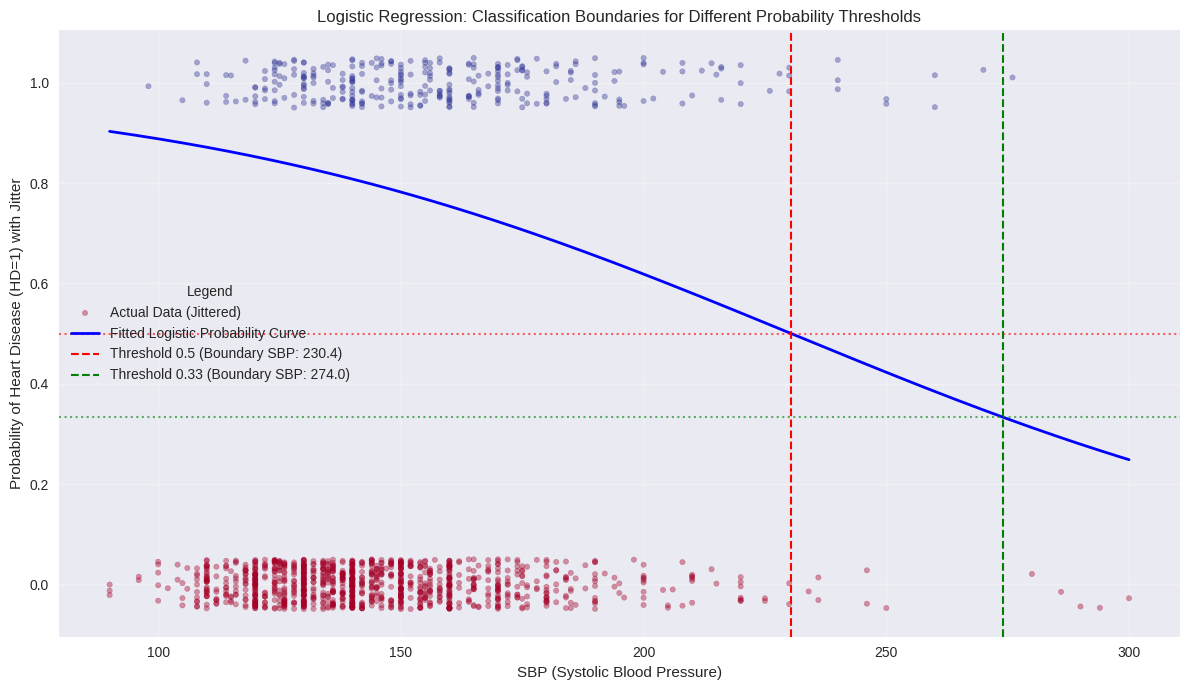

In [34]:
# Classification with threshold = 1/3
threshold_2 = 1/3  # Define the second threshold

# Calculate classifications based on the second threshold
classifications_2 = (predictions_1 > threshold_2).astype(int)

# Calculate the linear boundary for threshold 1/3
# The log odds threshold corresponding to a probability p is log(p / (1-p))
logit_threshold_2 = np.log(threshold_2 / (1 - threshold_2))
# The linear boundary SBP value is where logit = logit_threshold
# beta_0 + beta_1 * SBP = logit_threshold_2
# SBP = (logit_threshold_2 - beta_0) / beta_1
boundary_2 = (logit_threshold_2 - intercept) / slope

print(f"--- Classification Rule for Threshold {threshold_2:.3f} ---")
print(f"Rule: Classify HD=1 if Predicted Probability P(HD=1) > {threshold_2:.3f}")
print(f"Equivalent Rule in Log Odds: Classify HD=1 if Log Odds > {logit_threshold_2:.3f}")
print(f"Equivalent Rule in SBP: Classify HD=1 if SBP > {boundary_2:.2f}")

# --- Visualize Classification Boundaries ---
plt.figure(figsize=(12, 7))  # Create a figure with a specific size for better visibility

# Scatter plot of data with jitter
plt.scatter(fram_data_cleaned['SBP'], jittered_y,
            c=fram_data_cleaned['HD_numeric'], cmap='RdYlBu',
            alpha=0.4, s=15, label='Actual Data (Jittered)') # Added label for legend

# Plot the logistic probability curve
plt.plot(sbp_range, prob_values, 'b-', linewidth=2,
         label='Fitted Logistic Probability Curve') # Improved label

# Add vertical line for the SBP boundary at threshold 0.5
plt.axvline(x=boundary_1, color='red', linestyle='--', linewidth=1.5,
            label=f'Threshold 0.5 (Boundary SBP: {boundary_1:.1f})') # Clearer label

# Add vertical line for the SBP boundary at threshold 1/3
plt.axvline(x=boundary_2, color='green', linestyle='--', linewidth=1.5,
            label=f'Threshold {threshold_2:.2f} (Boundary SBP: {boundary_2:.1f})') # Clearer label

# Add horizontal lines for the probability thresholds
plt.axhline(y=0.5, color='red', linestyle=':', alpha=0.6, linewidth=1.5)
plt.axhline(y=threshold_2, color='green', linestyle=':', alpha=0.6, linewidth=1.5)

# Add labels and title
plt.xlabel('SBP (Systolic Blood Pressure)')
plt.ylabel('Probability of Heart Disease (HD=1) with Jitter')
plt.title('Logistic Regression: Classification Boundaries for Different Probability Thresholds')

# Add legend - try moving the location
plt.legend(title='Legend', loc='best') # Use 'best' to let matplotlib find a good location

# Add grid
plt.grid(True, alpha=0.3)

plt.tight_layout() # Ensure elements fit within the figure area

# Show the plot
plt.show()

Different thresholds create different classification boundaries. Lower thresholds (like 1/3) are more "sensitive" - they classify more people as having HD. The `np.log()` computes natural logarithm. The formula $logit = \log(p/(1-p))$ converts probability to log odds. The `plt.axvline()` adds vertical lines showing where the classification boundary falls on the SBP axis.

### 3.2 Criteria for Classifier

Given different classifiers, how can we tell which one is better? Let's evaluate performance using various criteria.

#### 3.2.1 Confusion Matrix

Confusion Matrix (threshold = 0.5):
Predicted:  0    1
Actual 0:   11 1084
Actual 1:    9  302


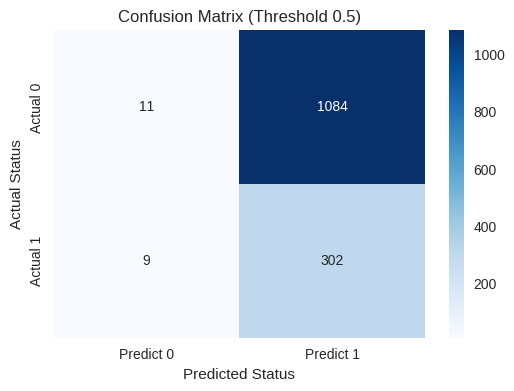

In [37]:
# Create confusion matrix for threshold = 0.5
# Drop rows with missing HD before converting to integer
y_true = fram_data.dropna(subset=['HD'])['HD'].astype(int)  # true labels as integers, dropping NaNs
y_pred = classifications_1.loc[y_true.index]  # predicted labels, aligning with cleaned true labels

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)  # compute confusion matrix
print("Confusion Matrix (threshold = 0.5):")  # label
print("Predicted:  0    1")  # column headers
print(f"Actual 0: {cm[0,0]:4d} {cm[0,1]:4d}")  # first row (True Negatives, False Positives)
print(f"Actual 1: {cm[1,0]:4d} {cm[1,1]:4d}")  # second row (False Negatives, True Positives)

# Create a heatmap for better visualization
plt.figure(figsize=(6, 4))  # create figure
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',  # heatmap with annotations
           xticklabels=['Predict 0', 'Predict 1'],  # x labels
           yticklabels=['Actual 0', 'Actual 1'])  # y labels
plt.title('Confusion Matrix (Threshold 0.5)')  # title
plt.ylabel('Actual Status') # y-axis label
plt.xlabel('Predicted Status') # x-axis label
plt.show()  # display

### Understanding the Confusion Matrix

Now that we can classify individuals based on our logistic regression model, how do we evaluate how *good* our classification rule is? This is where the **Confusion Matrix** comes in.

Think of the confusion matrix as a summary table that shows how many of our model's predictions were correct and how many were incorrect, compared to the actual true status of each individual. It's particularly useful for binary classification problems (like predicting Heart Disease or not), where there are only two possible outcomes: the event happens (Positive, P) or it doesn't (Negative, N).

Let's break down the structure of the confusion matrix:

|                   | **Predicted Negative (0)** | **Predicted Positive (1)** | **Total Actual** |
| :---------------- | :------------------------- | :------------------------- | :--------------- |
| **Actual Negative (0)** | True Negatives (TN)        | False Positives (FP)       | Actual Negatives |
| **Actual Positive (1)** | False Negatives (FN)       | True Positives (TP)        | Actual Positives |
| **Total Predicted** | Predicted Negatives        | Predicted Positives        | Total Observations |

Here's what each cell in the matrix represents, using our Heart Disease example:

*   **True Negatives (TN):** The number of individuals who *actually* do not have heart disease (Actual 0/Negative) and were *correctly predicted* as not having heart disease (Predicted 0/Negative). These are correct predictions.
*   **False Positives (FP):** The number of individuals who *actually* do not have heart disease (Actual 0/Negative) but were *incorrectly predicted* as having heart disease (Predicted 1/Positive). These are Type I errors, sometimes called a "false alarm."
*   **False Negatives (FN):** The number of individuals who *actually* have heart disease (Actual 1/Positive) but were *incorrectly predicted* as not having heart disease (Predicted 0/Negative). These are Type II errors, sometimes called a "miss."
*   **True Positives (TP):** The number of individuals who *actually* have heart disease (Actual 1/Positive) and were *correctly predicted* as having heart disease (Predicted 1/Positive). These are correct predictions.

**Why do we use it?**

A confusion matrix gives us a more detailed view of performance than just overall accuracy. Overall accuracy ($\frac{TN + TP}{TN + FP + FN + TP}$) can be misleading, especially when one class is much more common than the other (this is called an **imbalanced dataset**). For example, if only 10% of people have heart disease, a model that always predicts "no heart disease" would have 90% accuracy, but it would be useless for identifying actual cases! The confusion matrix shows us where the errors are occurring (missing actual cases vs. incorrectly flagging healthy individuals). Different types of errors (FP vs. FN) often have very different consequences in real-world applications.

**How is it Computed?**

The `sklearn.metrics.confusion_matrix()` function automatically computes this matrix for you. It takes the true labels (`y_true`) and your model's predicted labels (`y_pred`) and simply counts how many observations fall into each of the four categories (TN, FP, FN, TP) by comparing the actual and predicted labels for every individual in the dataset.

**Interpreting the Output (from the code cell):**

Using the output from the previous code cell (with the 0.5 threshold):

The confusion matrix is a 2×2 table showing classification results. The `confusion_matrix()` function counts: True Negatives (top-left), False Positives (top-right), False Negatives (bottom-left), and True Positives (bottom-right). The `sns.heatmap()` visualizes the matrix with colors where `annot=True` shows numbers and `fmt='d'` formats them as integers.

#### 3.2.2 Sensitivity and Specificity

In [38]:
# Calculate performance metrics
tn = cm[0, 0]  # true negatives (correctly predicted 0)
fp = cm[0, 1]  # false positives (incorrectly predicted 1)
fn = cm[1, 0]  # false negatives (incorrectly predicted 0)
tp = cm[1, 1]  # true positives (correctly predicted 1)

sensitivity = tp / (tp + fn)  # P(predict 1 | actual 1) - true positive rate
specificity = tn / (tn + fp)  # P(predict 0 | actual 0) - true negative rate
false_positive_rate = fp / (tn + fp)  # P(predict 1 | actual 0)
accuracy = (tp + tn) / (tp + tn + fp + fn)  # overall accuracy

print(f"Performance Metrics:")  # label
print(f"Sensitivity (TPR): {sensitivity:.4f}")  # sensitivity
print(f"Specificity (TNR): {specificity:.4f}")  # specificity
print(f"False Positive Rate: {false_positive_rate:.4f}")  # FPR
print(f"Accuracy: {accuracy:.4f}")  # accuracy

Performance Metrics:
Sensitivity (TPR): 0.9711
Specificity (TNR): 0.0100
False Positive Rate: 0.9900
Accuracy: 0.2226


### Understanding Sensitivity, Specificity, and Other Metrics

While the confusion matrix gives us a raw count of correct and incorrect predictions, we often use derived metrics to get a more standardized understanding of a classifier's performance. The code cell above calculates several of these key metrics.

Let's look at what each metric means and how it's calculated from the confusion matrix:

1.  **Sensitivity (True Positive Rate - TPR):**
    *   **What it measures:** The proportion of actual positive cases (those who *actually* have Heart Disease) that were correctly identified by the model. It tells us how good the model is at finding all the positive instances.
    *   **Calculation:** Sensitivity is the number of True Positives divided by the total number of actual positive cases (True Positives + False Negatives).
    *   **Formula:** $Sensitivity = TPR = \frac{TP}{TP + FN}$
    *   **Interpretation of Output:** From the code output, Sensitivity is **0.9711**. This means that out of all individuals who actually had heart disease in our dataset, the model correctly identified about 97.11% of them as having heart disease using the 0.5 probability threshold. This seems quite high!

2.  **Specificity (True Negative Rate - TNR):**
    *   **What it measures:** The proportion of actual negative cases (those who *actually* do *not* have Heart Disease) that were correctly identified by the model. It tells us how good the model is at correctly identifying negative instances and avoiding false alarms.
    *   **Calculation:** Specificity is the number of True Negatives divided by the total number of actual negative cases (True Negatives + False Positives).
    *   **Formula:** $Specificity = TNR = \frac{TN}{TN + FP}$
    *   **Interpretation of Output:** From the code output, Specificity is **0.0100**. This means that out of all individuals who actually did *not* have heart disease, the model correctly identified only about 1.00% of them as not having heart disease. This is extremely low!

3.  **False Positive Rate (FPR):**
    *   **What it measures:** The proportion of actual negative cases (those who *actually* do not have Heart Disease) that were *incorrectly* identified as positive by the model (False Positives). It's the rate of Type I errors.
    *   **Calculation:** False Positive Rate is the number of False Positives divided by the total number of actual negative cases (True Negatives + False Positives).
    *   **Formula:** $FPR = \frac{FP}{TN + FP}$
    *   **Relationship to Specificity:** Notice that $FPR = 1 - Specificity$.
    *   **Interpretation of Output:** From the code output, the False Positive Rate is **0.9900**. This confirms our low specificity; about 99.00% of individuals who were actually healthy were incorrectly classified as having heart disease. This is a very high false alarm rate!

4.  **Accuracy:**
    *   **What it measures:** The overall proportion of correct predictions (both True Positives and True Negatives) out of all predictions.
    *   **Calculation:** Accuracy is the sum of True Positives and True Negatives divided by the total number of observations.
    *   **Formula:** $Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$
    *   **Interpretation of Output:** From the code output, Accuracy is **0.2226**. This means only about 22.26% of all predictions were correct.

**Connecting to the Confusion Matrix and the 0.5 Threshold:**

Let's use the counts from the confusion matrix you saw earlier (with the 0.5 threshold):

*   TN = 11
*   FP = 1084
*   FN = 9
*   TP = 302

Now, let's manually calculate the metrics using these numbers:

*   Sensitivity = $\frac{TP}{TP + FN} = \frac{302}{302 + 9} = \frac{302}{311} \approx 0.9711$ (Matches the output!)
*   Specificity = $\frac{TN}{TN + FP} = \frac{11}{11 + 1084} = \frac{11}{1095} \approx 0.0100$ (Matches the output!)
*   False Positive Rate = $\frac{FP}{TN + FP} = \frac{1084}{11 + 1084} = \frac{1084}{1095} \approx 0.9900$ (Matches the output!)
*   Accuracy = $\frac{TP + TN}{TP + TN + FP + FN} = \frac{302 + 11}{302 + 11 + 1084 + 9} = \frac{313}{1406} \approx 0.2226$ (Matches the output!)

**Why are Sensitivity and Specificity often more informative than Accuracy? The Imbalanced Dataset Problem**

Our dataset is **imbalanced**: there are many more people without heart disease (Actual 0, 1095 observations) than people with heart disease (Actual 1, 311 observations).

*   If we only looked at Accuracy (22.26%), it seems like a very poor model.
*   However, looking at Sensitivity (97.11%) and Specificity (1.00%) tells a much clearer story. The model is *very good* at identifying people who *do* have heart disease (high sensitivity), but it's *terrible* at correctly identifying people who *don't* have heart disease (very low specificity, very high false positive rate). It's essentially classifying almost everyone as having heart disease when using the 0.5 threshold! This results in a low overall accuracy despite high sensitivity because it makes so many false positive errors on the large number of healthy individuals.

In imbalanced datasets, a model can achieve high accuracy by simply predicting the majority class most of the time. Sensitivity and Specificity (or Precision and Recall, which we might see later) provide a better picture of how well the model performs on *each* class, especially the minority class which is often the one we are most interested in detecting (like a disease, fraud, etc.).

**Real-world Implications and Fairness (e.g., COMPAS)**

The choice of classification threshold and the resulting balance between Sensitivity and Specificity have significant real-world consequences.

Consider a model used in the justice system to predict the likelihood of a defendant reoffending (recidivism). The COMPAS algorithm is a well-known example.

*   **Positive (1):** Predicted to reoffend.
*   **Negative (0):** Predicted not to reoffend.
*   **Actual Positive (1):** Defendant actually reoffends.
*   **Actual Negative (0):** Defendant does not reoffend.

*   **False Positive (FP):** Predicting someone will reoffend, but they don't. This can lead to harsher sentencing or denial of parole for someone who would not have committed another crime.
*   **False Negative (FN):** Predicting someone will *not* reoffend, but they do. This can lead to releasing someone who then commits another crime, potentially harming the community.

In systems like COMPAS, it's been shown that the rates of False Positives and False Negatives can differ significantly across racial groups, even if overall accuracy is similar. This is a major issue of **algorithmic fairness**. A model might have higher False Positive rates for one group (e.g., classifying more individuals from that group as high risk when they are not) and higher False Negative rates for another. Evaluating metrics like Sensitivity and Specificity *per group* is crucial for understanding and addressing these fairness concerns.

In our heart disease example, a high False Positive rate (low specificity) means many healthy people would be incorrectly told they have heart disease, potentially leading to unnecessary stress, further testing, and treatment costs. A high False Negative rate (low sensitivity) means people with heart disease are missed, delaying diagnosis and treatment. The optimal balance depends on the cost of each type of error. For a serious condition like heart disease, we might prioritize high sensitivity (finding most cases) even if it means a higher false positive rate.

These metrics, derived from the confusion matrix, are essential tools for understanding not just how "accurate" a model is overall, but *how* and *where* it makes mistakes, which is critical for both performance evaluation and ensuring fairness.

**Sensitivity** (True Positive Rate) measures the proportion of actual positives correctly identified: $P(\hat{Y}=1|Y=1)$. **Specificity** (True Negative Rate) measures the proportion of actual negatives correctly identified: $P(\hat{Y}=0|Y=0)$. The **False Positive Rate** equals $1 - Specificity$. **Accuracy** is the proportion of all correct predictions.

#### 3.2.3 ROC Curve and AUC

The ROC (Receiver Operating Characteristic) curve shows the trade-off between sensitivity and false positive rate across all thresholds:

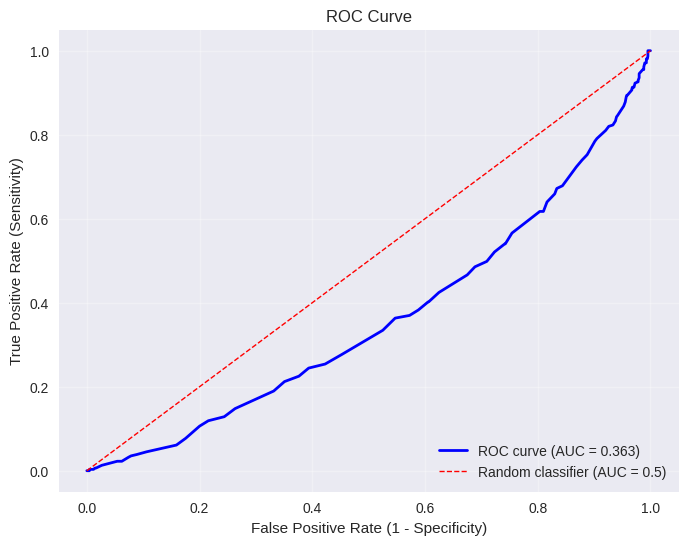

Area Under Curve (AUC): 0.3630


In [40]:
# Calculate ROC curve
# Ensure predictions align with the cleaned true labels
predictions_for_roc = predictions_1.loc[y_true.index]
fpr, tpr, thresholds = roc_curve(y_true, predictions_for_roc)  # false positive rate, true positive rate, thresholds
roc_auc = auc(fpr, tpr)  # area under the curve

# Plot ROC curve
plt.figure(figsize=(8, 6))  # create figure
plt.plot(fpr, tpr, 'b-', linewidth=2,  # ROC curve
        label=f'ROC curve (AUC = {roc_auc:.3f})')  # label with AUC
plt.plot([0, 1], [0, 1], 'r--', linewidth=1,  # diagonal reference line
        label='Random classifier (AUC = 0.5)')  # label
plt.xlabel('False Positive Rate (1 - Specificity)')  # x label
plt.ylabel('True Positive Rate (Sensitivity)')  # y label
plt.title('ROC Curve')  # title
plt.legend(loc='lower right')  # legend position
plt.grid(True, alpha=0.3)  # add grid
plt.show()  # display

print(f"Area Under Curve (AUC): {roc_auc:.4f}")  # display AUC value

### Understanding the ROC Curve and AUC

While the confusion matrix gives us a snapshot of performance at a *specific* classification threshold, the **Receiver Operating Characteristic (ROC) curve** and the **Area Under the Curve (AUC)** provide a way to evaluate a classifier's performance across *all possible thresholds*.

Let's explain the output from the code cell above:

1.  **The ROC Curve:**
    *   **What it is:** The ROC curve is a plot that shows the trade-off between the **True Positive Rate (Sensitivity)** on the y-axis and the **False Positive Rate (1 - Specificity)** on the x-axis for different classification thresholds.
    *   **How it's generated:** The code calculates the TPR and FPR for every possible threshold that can be derived from the predicted probabilities. Starting from a high threshold (where both TPR and FPR are low, near (0,0)), as the threshold is lowered, both TPR (we correctly identify more positives) and FPR (we incorrectly classify more negatives as positive) generally increase. The curve traces this movement.
    *   **Interpreting the Plot:**
        *   The **blue curve** is the ROC curve for our logistic regression model (using SBP as the only predictor).
        *   The **red dashed line** represents a **random classifier**. A random classifier would, on average, have a TPR equal to its FPR, resulting in a diagonal line from (0,0) to (1,1).
        *   A **perfect classifier** (one that makes no mistakes) would have a TPR of 1 and an FPR of 0 for some threshold, resulting in a curve that goes straight up from (0,0) to (0,1) and then across to (1,1).
        *   A good classifier's ROC curve will be **above and to the left** of the random classifier line, indicating that it achieves a higher TPR for a given FPR (or a lower FPR for a given TPR) compared to random chance.

2.  **The Area Under the Curve (AUC):**
    *   **What it is:** The AUC is a single scalar value that summarizes the overall performance of a binary classifier across all possible thresholds. It is literally the area under the ROC curve.
    *   **How it's calculated:** The `sklearn.metrics.auc()` function calculates this area.
    *   **Interpreting the Value:**
        *   The AUC ranges from 0 to 1.
        *   An AUC of **0.5** corresponds to a random classifier (the area under the red diagonal line).
        *   An AUC of **1.0** corresponds to a perfect classifier.
        *   An AUC **below 0.5** indicates a classifier that performs *worse* than random chance (it's often predicting the wrong class more often than the right one, potentially due to mislabeled data or issues with the model).
        *   A higher AUC indicates a better-performing model at distinguishing between the positive and negative classes.
    *   **Interpretation of Our Output:** The code output shows an **AUC of 0.3630**. This value is *below* 0.5, which is quite low and indicates that our simple logistic regression model using only SBP as a predictor is not performing well at distinguishing between individuals with and without heart disease in this dataset. The ROC curve confirms this, as it falls below the random classifier line. This suggests that SBP alone is not a strong predictor of Heart Disease in this context, or perhaps the relationship is more complex than a simple logistic model can capture, or there might be issues with the data or model fitting (though the fit summary looked reasonable).

**Why are ROC and AUC useful?**

*   **Threshold-Independent Evaluation:** Unlike metrics from the confusion matrix at a fixed threshold, AUC gives an overall measure of performance regardless of the chosen threshold.
*   **Comparison of Models:** AUC is a good metric for comparing different classification models. A model with a higher AUC is generally considered better than a model with a lower AUC.
*   **Handles Imbalanced Data:** AUC is less affected by imbalanced datasets compared to accuracy. Even with a highly imbalanced dataset, a good model will still have a high AUC if it can effectively rank the positive and negative cases.

In summary, the ROC curve and AUC are crucial tools for evaluating the discriminative power of a classification model. Our current model's low AUC suggests we need to explore additional predictors or more complex models to improve performance.

The `roc_curve()` function computes FPR and TPR for all possible thresholds. Each point on the ROC curve represents a different threshold. The diagonal line represents a random classifier (AUC = 0.5). The `auc()` function calculates the area under the ROC curve. AUC ranges from 0 to 1, where higher values indicate better discrimination. AUC = 1 means perfect classification.

Let's examine how thresholds affect the ROC curve:

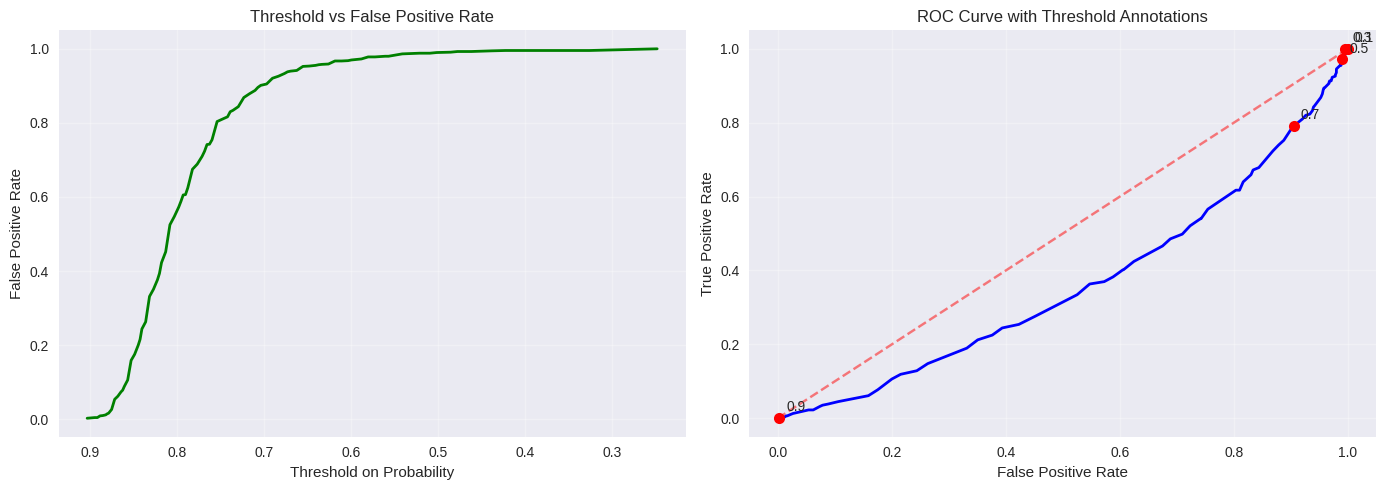

In [41]:
# Show relationship between thresholds and ROC points
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # create 2 subplots

# Plot 1: Thresholds vs FPR
axes[0].plot(thresholds[1:], fpr[1:], 'g-', linewidth=2)  # skip first point (threshold=inf)
axes[0].set_xlabel('Threshold on Probability')  # x label
axes[0].set_ylabel('False Positive Rate')  # y label
axes[0].set_title('Threshold vs False Positive Rate')  # title
axes[0].grid(True, alpha=0.3)  # grid
axes[0].invert_xaxis()  # invert x-axis for intuitive reading

# Plot 2: ROC with threshold annotations
axes[1].plot(fpr, tpr, 'b-', linewidth=2)  # ROC curve

# Annotate specific thresholds
threshold_points = [0.1, 0.3, 0.5, 0.7, 0.9]  # thresholds to annotate
for t in threshold_points:  # loop through thresholds
    idx = np.argmin(np.abs(thresholds - t))  # find closest threshold index
    axes[1].plot(fpr[idx], tpr[idx], 'ro', markersize=8)  # mark point
    axes[1].annotate(f'{t:.1f}',  # annotation text
                    xy=(fpr[idx], tpr[idx]),  # point location
                    xytext=(5, 5), textcoords='offset points')  # text offset

axes[1].plot([0, 1], [0, 1], 'r--', alpha=0.5)  # diagonal line
axes[1].set_xlabel('False Positive Rate')  # x label
axes[1].set_ylabel('True Positive Rate')  # y label
axes[1].set_title('ROC Curve with Threshold Annotations')  # title
axes[1].grid(True, alpha=0.3)  # grid

plt.tight_layout()  # adjust spacing
plt.show()  # display

### Exploring Thresholds and the ROC Curve

The code above generates two plots that visually connect the classification probability threshold to its corresponding point on the ROC curve. Understanding this relationship is key to selecting an appropriate threshold for your specific application.

1.  **Left Plot: Threshold vs. False Positive Rate:**
    *   This plot shows how the False Positive Rate (FPR) changes as we vary the classification probability threshold.
    *   Remember that the FPR is the rate of incorrectly classifying a negative case as positive ($\frac{FP}{TN + FP}$).
    *   The x-axis represents the probability threshold (inverted for easier reading, so lower probabilities are on the right, corresponding to less strict classification rules).
    *   The y-axis shows the resulting FPR.
    *   As the threshold decreases (moving from left to right on the inverted x-axis), the model is more likely to predict the positive class (HD=1). This leads to an increase in False Positives (classifying more healthy individuals as having HD), and thus the FPR increases.
2.  **Right Plot: ROC Curve with Threshold Annotations:**
    *   This is the standard ROC curve we saw before, plotting True Positive Rate (Sensitivity) vs. False Positive Rate.
    *   The colored points on the curve represent the specific thresholds (0.1, 0.3, 0.5, 0.7, 0.9) annotated in the plot.
    *   Each point on the ROC curve corresponds to the Sensitivity and False Positive Rate you would get if you used that specific probability threshold for classification.
    *   As you move along the curve from the bottom left towards the top right, you are effectively decreasing the classification threshold.
        *   A high threshold (e.g., 0.9 or 0.7) is strict; the model only predicts HD=1 when it's very confident. This results in a low FPR (fewer healthy people misclassified) but also a low TPR (many actual HD cases are missed). These points are towards the bottom left of the curve.
        *   A low threshold (e.g., 0.1 or 0.3) is lenient; the model predicts HD=1 even when it's less confident. This results in a high TPR (more actual HD cases are found) but also a high FPR (more healthy people are misclassified). These points are towards the top right of the curve.

These plots demonstrate the inherent trade-off when choosing a classification threshold: increasing Sensitivity (correctly finding more positive cases) often comes at the cost of increasing the False Positive Rate (incorrectly flagging more negative cases as positive), and vice-versa. The optimal threshold depends on the specific costs associated with each type of error in the real-world application.

The `plt.subplots()` creates multiple plots in one figure. The `np.argmin(np.abs())` finds the index of the minimum absolute difference. The `axes[0].invert_xaxis()` reverses the x-axis direction. As the threshold decreases, we move along the ROC curve from bottom-left (high threshold, few positives) to top-right (low threshold, many positives).

#### 3.2.4 Misclassification Error

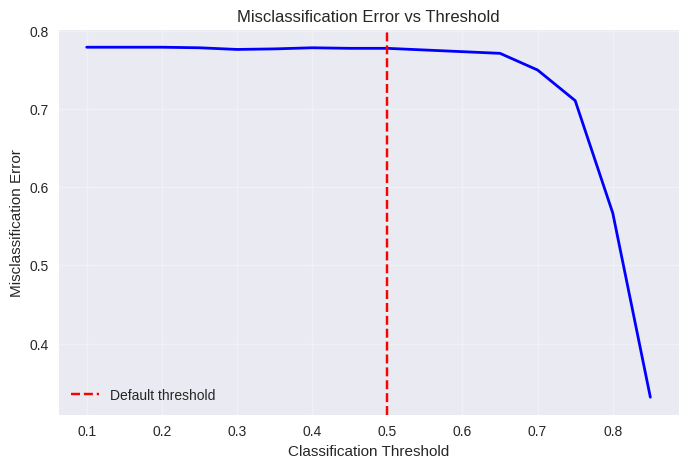

Optimal threshold for minimum error: 0.850
Minimum misclassification error: 0.3314


In [43]:
# Calculate misclassification error for different thresholds
thresholds_to_test = np.arange(0.1, 0.9, 0.05)  # range of thresholds from 0.1 to 0.9
errors = []  # list to store errors

# Align predictions with y_true by index
predictions_aligned = predictions_1.loc[y_true.index]

for thresh in thresholds_to_test:  # loop through thresholds
    y_pred_thresh = (predictions_aligned > thresh).astype(int)  # classify with threshold
    error = np.mean(y_pred_thresh != y_true)  # proportion of misclassifications
    errors.append(error)  # add to list

# Plot misclassification error vs threshold
plt.figure(figsize=(8, 5))  # create figure
plt.plot(thresholds_to_test, errors, 'b-', linewidth=2)  # error curve
plt.xlabel('Classification Threshold')  # x label
plt.ylabel('Misclassification Error')  # y label
plt.title('Misclassification Error vs Threshold')  # title
plt.grid(True, alpha=0.3)  # grid
plt.axvline(x=0.5, color='r', linestyle='--',  # mark threshold 0.5
           label='Default threshold')  # label
plt.legend()  # show legend
plt.show()  # display

# Find optimal threshold for minimum error
optimal_thresh = thresholds_to_test[np.argmin(errors)]  # threshold with minimum error
min_error = np.min(errors)  # minimum error value
print(f"Optimal threshold for minimum error: {optimal_thresh:.3f}")  # display
print(f"Minimum misclassification error: {min_error:.4f}")  # display

The misclassification error equals the proportion of incorrect predictions: $(FP + FN) / N$. The `np.arange(0.1, 0.9, 0.05)` creates values from 0.1 to 0.85 in steps of 0.05. The `np.mean()` calculates the average of boolean values (True=1, False=0). Different thresholds optimize different criteria - the threshold minimizing error may differ from the one maximizing sensitivity.

#### 3.2.5 False Discovery Rate (FDR)

In [44]:
# Calculate FDR and related metrics
positive_predictive_value = tp / (tp + fp) if (tp + fp) > 0 else 0  # P(Y=1 | predict=1)
negative_predictive_value = tn / (tn + fn) if (tn + fn) > 0 else 0  # P(Y=0 | predict=0)
fdr = fp / (tp + fp) if (tp + fp) > 0 else 0  # P(Y=0 | predict=1)

print(f"\nPredictive Values:")  # label
print(f"Positive Predictive Value (Precision): {positive_predictive_value:.4f}")  # PPV
print(f"Negative Predictive Value: {negative_predictive_value:.4f}")  # NPV
print(f"False Discovery Rate (FDR): {fdr:.4f}")  # FDR


Predictive Values:
Positive Predictive Value (Precision): 0.2179
Negative Predictive Value: 0.5500
False Discovery Rate (FDR): 0.7821


The **Positive Predictive Value** (Precision) is $P(Y=1|\hat{Y}=1)$ - the probability that a positive prediction is correct. The **False Discovery Rate** is $P(Y=0|\hat{Y}=1)$ - the proportion of positive predictions that are wrong. Note that FDR = 1 - PPV. The conditional expressions handle division by zero when no positive predictions are made.

## 4. Multiple Logistic Regression and Classification

We've introduced logistic regression with one predictor. Let's extend to multiple predictors.

### 4.1 Data Preparation

First, let's remove missing values (though this is generally not recommended):

In [45]:
# Check for missing values
print("Missing values per column:")  # label
print(fram_data.isnull().sum())  # count NaN per column

# Remove rows with any missing values
fram_data_complete = fram_data.dropna()  # drop rows with NaN
print(f"\nOriginal data: {len(fram_data)} rows")  # original size
print(f"After removing missing: {len(fram_data_complete)} rows")  # new size
print(f"Rows removed: {len(fram_data) - len(fram_data_complete)}")  # difference

Missing values per column:
HD       1
AGE      0
SEX      0
SBP      0
DBP      0
CHOL     0
FRW     11
CIG      2
dtype: int64

Original data: 1407 rows
After removing missing: 1393 rows
Rows removed: 14


The `.dropna()` method removes any row containing at least one missing value. This is a simple but potentially problematic approach as it reduces sample size and may introduce bias if missingness is not random.

### 4.2 Multiple Logistic Regression

With multiple predictors $x = (x_1, x_2, ..., x_p)$, the logit link becomes:

$$logit(P(HD=1|x)) = \log\left(\frac{P(HD=1|x)}{P(HD=0|x)}\right) = \beta_0 + \beta_1 x_1 + ... + \beta_p x_p$$

where

$$P(HD=1|x) = \frac{e^{\beta_0 + \beta_1 x_1 + ... + \beta_p x_p}}{1 + e^{\beta_0 + \beta_1 x_1 + ... + \beta_p x_p}}$$

Let's fit the full model:

In [46]:
# Fit multiple logistic regression with all predictors
fit2 = smf.glm('HD ~ AGE + SEX + SBP + DBP + CHOL + FRW + CIG',  # all predictors
              data=fram_data_complete,  # complete cases only
              family=sm.families.Binomial())  # binomial family
fit2_result = fit2.fit()  # fit using MLE

print("Multiple Logistic Regression Results:")  # label
print(fit2_result.summary())  # display full summary

Multiple Logistic Regression Results:
                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['HD[0.0]', 'HD[1.0]']   No. Observations:                 1393
Model:                                GLM   Df Residuals:                     1385
Model Family:                    Binomial   Df Model:                            7
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -671.57
Date:                    Wed, 22 Oct 2025   Deviance:                       1343.1
Time:                            02:54:07   Pearson chi2:                 1.36e+03
No. Iterations:                         5   Pseudo R-squ. (CS):            0.08661
Covariance Type:                nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------

The formula includes all predictors separated by `+`. Categorical variables like SEX are automatically converted to dummy variables. The model estimates one coefficient per predictor plus an intercept. Each coefficient represents the change in log odds for a one-unit increase in that predictor, holding all other predictors constant.

#### 4.1.1 Wald Intervals and Tests

In [47]:
# Extract coefficient summary
coef_summary = pd.DataFrame({  # create DataFrame
    'Coefficient': fit2_result.params,  # estimates
    'Std Error': fit2_result.bse,  # standard errors
    'z-value': fit2_result.tvalues,  # z-statistics
    'p-value': fit2_result.pvalues,  # p-values
    'Lower CI': fit2_result.conf_int()[0],  # lower confidence bound
    'Upper CI': fit2_result.conf_int()[1]  # upper confidence bound
})

print("Coefficient Summary with 95% Confidence Intervals:")  # label
print(coef_summary.round(4))  # round to 4 decimal places

# Identify significant predictors
significant = coef_summary[coef_summary['p-value'] < 0.05]  # filter by p-value
print(f"\nSignificant predictors (p < 0.05):")  # label
print(significant.index.tolist())  # list significant variables

Coefficient Summary with 95% Confidence Intervals:
             Coefficient  Std Error  z-value  p-value  Lower CI  Upper CI
Intercept         9.3348     1.0367   9.0047   0.0000    7.3030   11.3666
SEX[T.MALE]      -0.9061     0.1576  -5.7478   0.0000   -1.2151   -0.5971
AGE              -0.0625     0.0150  -4.1672   0.0000   -0.0919   -0.0331
SBP              -0.0148     0.0039  -3.8179   0.0001   -0.0225   -0.0072
DBP              -0.0029     0.0076  -0.3773   0.7059   -0.0178    0.0121
CHOL             -0.0045     0.0015  -2.9623   0.0031   -0.0074   -0.0015
FRW              -0.0058     0.0041  -1.4291   0.1530   -0.0137    0.0022
CIG              -0.0123     0.0061  -2.0222   0.0432   -0.0242   -0.0004

Significant predictors (p < 0.05):
['Intercept', 'SEX[T.MALE]', 'AGE', 'SBP', 'CHOL', 'CIG']


The DataFrame constructor organizes results into a table. The `.round(4)` method rounds all numeric values to 4 decimal places. Boolean indexing `[coef_summary['p-value'] < 0.05]` filters rows where p-value is less than 0.05. The `.index.tolist()` extracts row names (variable names) as a list.

#### 4.1.2 Likelihood Ratio Test

Test whether all risk factors together are useful:

In [51]:
# Compare full model with null model
import scipy.stats as stats # Import scipy.stats as stats
null_model = smf.glm('HD ~ 1', data=fram_data_complete,  # intercept only
                     family=sm.families.Binomial())  # binomial
null_result = null_model.fit()  # fit null model

# Likelihood ratio test
lr_stat = null_result.deviance - fit2_result.deviance  # test statistic
df = len(fit2_result.params) - 1  # degrees of freedom
p_value = 1 - stats.chi2.cdf(lr_stat, df)  # p-value from chi-squared

print(f"Likelihood Ratio Test (all predictors):")  # label
print(f"LR Statistic: {lr_stat:.2f}")  # statistic
print(f"Degrees of freedom: {df}")  # df
print(f"P-value: {p_value:.2e}")  # scientific notation
print(f"Conclusion: {'Reject H0' if p_value < 0.05 else 'Fail to reject H0'}")  # decision

# Using anova for likelihood ratio test
# anova_table = null_result.compare_anova(fit2_result)  # This line caused an error
# print("\nANOVA Table (Likelihood Ratio Test):")  # label
# print(anova_table)  # display

Likelihood Ratio Test (all predictors):
LR Statistic: 126.19
Degrees of freedom: 7
P-value: 0.00e+00
Conclusion: Reject H0


The test compares the full model against the null model with only an intercept. The null hypothesis is $H_0: \beta_1 = ... = \beta_p = 0$ (all predictors are useless). The test statistic follows a chi-squared distribution with degrees of freedom equal to the number of predictors. A small p-value indicates at least one predictor is useful.

### 4.3 Model Selection

Let's perform backward elimination to find a parsimonious model:

In [52]:
# Backward elimination function
def backward_elimination(data, response, predictors, alpha=0.05):  # function definition
    """Perform backward elimination for logistic regression"""  # docstring
    current_predictors = predictors.copy()  # copy list to avoid modifying original

    while True:  # loop until no more variables to remove
        # Fit current model
        formula = f"{response} ~ " + " + ".join(current_predictors)  # build formula string
        model = smf.glm(formula, data=data,  # fit model
                       family=sm.families.Binomial()).fit()  # binomial family

        # Get p-values
        p_values = model.pvalues[1:]  # exclude intercept
        max_p = p_values.max()  # find largest p-value

        if max_p > alpha:  # if largest p-value exceeds threshold
            # Remove variable with highest p-value
            remove_var = p_values.idxmax()  # variable with max p-value
            current_predictors.remove(remove_var.replace('[T.MALE]', ''))  # remove from list
            print(f"Removing {remove_var} (p={max_p:.4f})")  # display removal
        else:  # all variables significant
            break  # exit loop

    return model, current_predictors  # return final model and predictors

# Perform backward elimination
predictors = ['AGE', 'SEX', 'SBP', 'DBP', 'CHOL', 'FRW', 'CIG']  # all predictors
final_model, final_predictors = backward_elimination(fram_data_complete,  # call function
                                                     'HD', predictors)  # arguments

print(f"\nFinal predictors: {final_predictors}")  # display final variables
print("\nFinal Model Summary:")  # label
print(final_model.summary())  # display summary

Removing DBP (p=0.7059)
Removing FRW (p=0.1315)
Removing CIG (p=0.0608)

Final predictors: ['AGE', 'SEX', 'SBP', 'CHOL']

Final Model Summary:
                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['HD[0.0]', 'HD[1.0]']   No. Observations:                 1393
Model:                                GLM   Df Residuals:                     1388
Model Family:                    Binomial   Df Model:                            4
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -674.51
Date:                    Wed, 22 Oct 2025   Deviance:                       1349.0
Time:                            02:58:13   Pearson chi2:                 1.36e+03
No. Iterations:                         5   Pseudo R-squ. (CS):            0.08275
Covariance Type:                nonrobust                                         
                  coef    s

The function uses a while loop that continues until all remaining predictors are significant. The `" + ".join()` concatenates list elements with " + " between them. The `.idxmax()` returns the index (variable name) of the maximum value. The `.replace()` handles categorical variable notation in statsmodels. The function returns both the fitted model and the list of retained predictors.

### 4.4 Model Comparison using AIC

Akaike Information Criterion (AIC) balances model fit with complexity:

In [53]:
# Compare models using AIC
models = {}  # dictionary to store models

# Model 1: SBP only
models['SBP only'] = smf.glm('HD ~ SBP', data=fram_data_complete,  # single predictor
                             family=sm.families.Binomial()).fit()  # fit

# Model 2: SBP + AGE
models['SBP + AGE'] = smf.glm('HD ~ SBP + AGE', data=fram_data_complete,  # two predictors
                               family=sm.families.Binomial()).fit()  # fit

# Model 3: Final model from backward elimination
models['Final'] = final_model  # already fitted

# Model 4: Full model
models['Full'] = fit2_result  # already fitted

# Compare AIC
aic_comparison = pd.DataFrame({  # create comparison table
    'Model': models.keys(),  # model names
    'AIC': [m.aic for m in models.values()],  # AIC values
    'Deviance': [m.deviance for m in models.values()],  # deviance
    'Parameters': [len(m.params) for m in models.values()]  # number of parameters
})

aic_comparison = aic_comparison.sort_values('AIC')  # sort by AIC
print("Model Comparison (sorted by AIC):")  # label
print(aic_comparison)  # display

# Best model by AIC
best_model_name = aic_comparison.iloc[0]['Model']  # first row after sorting
print(f"\nBest model by AIC: {best_model_name}")  # display

Model Comparison (sorted by AIC):
       Model          AIC     Deviance  Parameters
2      Final  1359.010798  1349.010798           5
3       Full  1359.143031  1343.143031           8
1  SBP + AGE  1406.772997  1400.772997           3
0   SBP only  1421.467546  1417.467546           2

Best model by AIC: Final


### Model Selection using AIC (Akaike Information Criterion)

When we have multiple possible models (like our simple SBP model, a model with SBP and AGE, the one from backward elimination, and the full model), how do we decide which one is the "best"? We need a way to compare them.

While looking at p-values helps us understand the significance of individual predictors, AIC (Akaike Information Criterion) provides a way to compare the overall quality of different models that are fitted to the same data.

**What is AIC?**

AIC is an estimator of the relative amount of information lost when a particular model is used to represent the process that generates the data. In simpler terms, it's a measure that tries to balance two things:

1.  **How well the model fits the data:** A model that fits the data very closely will generally have a lower AIC.
2.  **How complex the model is:** Adding more predictors (making the model more complex) can improve the fit, but it also increases the risk of **overfitting** (where the model performs well on the training data but poorly on new, unseen data). AIC penalizes models for having more parameters (predictors).

The formula for AIC is:

$AIC = 2k - 2 \log(\mathcal{L})$

Where:
*   $k$ is the number of parameters in the model (including the intercept). More parameters mean a more complex model.
*   $\log(\mathcal{L})$ is the maximum value of the log-likelihood function for the model. The log-likelihood measures how likely the observed data is, given the model's parameters. A higher log-likelihood (closer to zero, or less negative) means the model fits the data better.

**How to Interpret AIC for Model Comparison:**

When comparing multiple models, the model with the **lowest AIC** is generally preferred. A lower AIC suggests a better balance between fitting the data well and keeping the model simple.

**Explanation of the Code and Output:**

The code cell does the following:

1.  It fits several different logistic regression models:
    *   `'SBP only'`: A model with just SBP as a predictor.
    *   `'SBP + AGE'`: A model with SBP and AGE as predictors.
    *   `'Final'`: The model we got from the backward elimination process.
    *   `'Full'`: The model with all the original predictors.
2.  It then creates a pandas DataFrame called `aic_comparison` to display the AIC, Deviance (which is related to the log-likelihood), and the number of parameters for each model.
3.  Finally, it sorts this table by AIC in ascending order (lowest AIC first).

**Interpreting the `aic_comparison` Output Table:**

Looking at the output table:

*   We see each model listed.
*   The `Parameters` column shows how many coefficients (including the intercept) are in each model. As expected, the 'Full' model has the most parameters (8), while the 'SBP only' model has the fewest (2).
*   The `Deviance` column is related to how well the model fits the data (lower deviance generally means better fit, similar to lower Residual Sum of Squares in linear regression). You can see the 'Full' model has the lowest Deviance (1343.1), which makes sense because it uses all predictors and should fit the training data best among these options.
*   The `AIC` column shows the calculated AIC value for each model.
*   The table is sorted by AIC. The model with the lowest AIC is at the top.

In this case, the **'Final' model** (which includes AGE, SEX, SBP, and CHOL after backward elimination) has the lowest AIC (1359.01). The 'Full' model is very close (1359.14). Both are significantly lower than the models with only one or two predictors.

AIC = Deviance + 2 × (number of parameters). Lower AIC indicates better model. The dictionary `models` stores different fitted models. List comprehension `[m.aic for m in models.values()]` extracts AIC from each model. The `.sort_values('AIC')` sorts DataFrame by AIC column in ascending order.

### 4.5 Final Model and Predictions

Let's use the selected model to make predictions:

In [54]:
# Use the final model for predictions
fit_final = final_model  # assign final model

# Predict for Alice
alice_pred_final = fit_final.predict(fram_data_new)  # predict probability
print(f"Alice's predicted probability (final model): {alice_pred_final.values[0]:.4f}")  # display

# Compare with simple model
alice_pred_simple = fit1_result.predict(fram_data_new)  # predict using SBP only
print(f"Alice's predicted probability (SBP only): {alice_pred_simple.values[0]:.4f}")  # display
print(f"Difference: {alice_pred_final.values[0] - alice_pred_simple.values[0]:.4f}")  # difference

Alice's predicted probability (final model): 0.9664
Alice's predicted probability (SBP only): 0.8883
Difference: 0.0781


Different models can produce substantially different probability estimates for the same individual. The more complex model incorporates additional risk factors, potentially providing more accurate predictions.

## 5. Classification Revisited

With multiple predictors, classification becomes more complex but follows the same principles.

### 5.1 Two Features Visualization

Let's visualize classification boundaries with two continuous predictors:

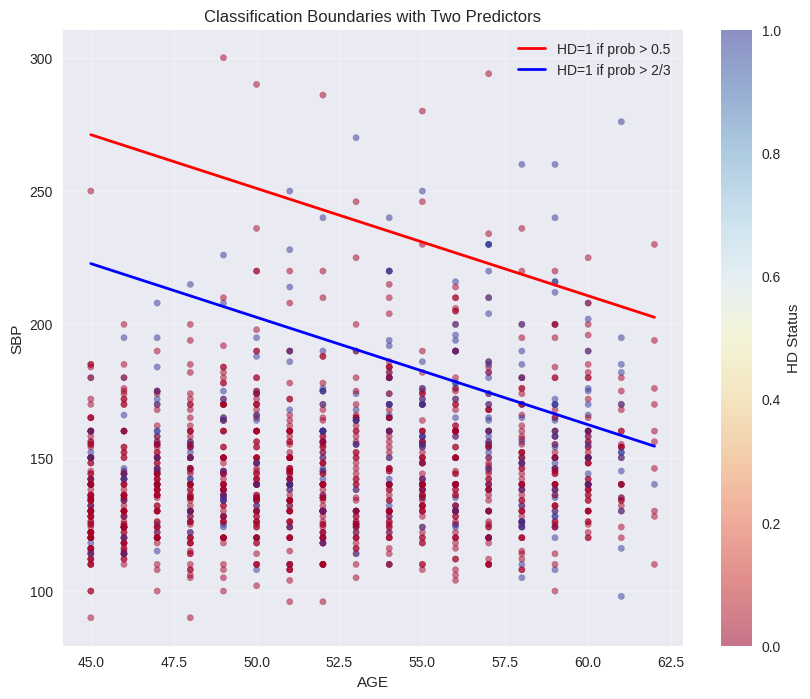

Logit equation: 6.486 + -0.0143*SBP + -0.0577*AGE


In [55]:
# Fit model with SBP and AGE
fit_2d = smf.glm('HD ~ SBP + AGE', data=fram_data_complete,  # two predictors
                 family=sm.families.Binomial()).fit()  # fit

# Extract coefficients
b0 = fit_2d.params['Intercept']  # intercept
b1 = fit_2d.params['SBP']  # SBP coefficient
b2 = fit_2d.params['AGE']  # AGE coefficient

# Calculate decision boundaries for different thresholds
# For threshold p: logit = log(p/(1-p))
# Decision boundary: b0 + b1*SBP + b2*AGE = logit_threshold
# Solving for SBP: SBP = (logit_threshold - b0 - b2*AGE) / b1

age_range = np.linspace(45, 62, 100)  # range of ages

# Boundary for p = 0.5
logit_05 = 0  # log(0.5/0.5) = 0
sbp_boundary_05 = (logit_05 - b0 - b2 * age_range) / b1  # solve for SBP

# Boundary for p = 2/3
logit_23 = np.log(2/3 / (1/3))  # log odds for p=2/3
sbp_boundary_23 = (logit_23 - b0 - b2 * age_range) / b1  # solve for SBP

# Visualize
plt.figure(figsize=(10, 8))  # create figure
plt.scatter(fram_data_complete['AGE'], fram_data_complete['SBP'],  # scatter plot
           c=fram_data_complete['HD'].astype(int),  # color by HD
           cmap='RdYlBu', alpha=0.5, s=20)  # styling

plt.plot(age_range, sbp_boundary_05, 'r-', linewidth=2,  # boundary for p=0.5
        label='HD=1 if prob > 0.5')  # label
plt.plot(age_range, sbp_boundary_23, 'b-', linewidth=2,  # boundary for p=2/3
        label='HD=1 if prob > 2/3')  # label

plt.xlabel('AGE')  # x label
plt.ylabel('SBP')  # y label
plt.title('Classification Boundaries with Two Predictors')  # title
plt.legend()  # show legend
plt.colorbar(label='HD Status')  # add colorbar
plt.grid(True, alpha=0.3)  # add grid
plt.show()  # display

print(f"Logit equation: {b0:.3f} + {b1:.4f}*SBP + {b2:.4f}*AGE")  # display equation

With two predictors, the decision boundary is a line in the 2D feature space. The equation $\beta_0 + \beta_1 \times SBP + \beta_2 \times AGE = c$ defines a line where $c$ depends on the threshold. Points above the line are classified as HD=1. Different thresholds produce parallel lines (same slope, different intercepts).

### 5.2 ROC Comparison of Models

Let's compare ROC curves for different models:

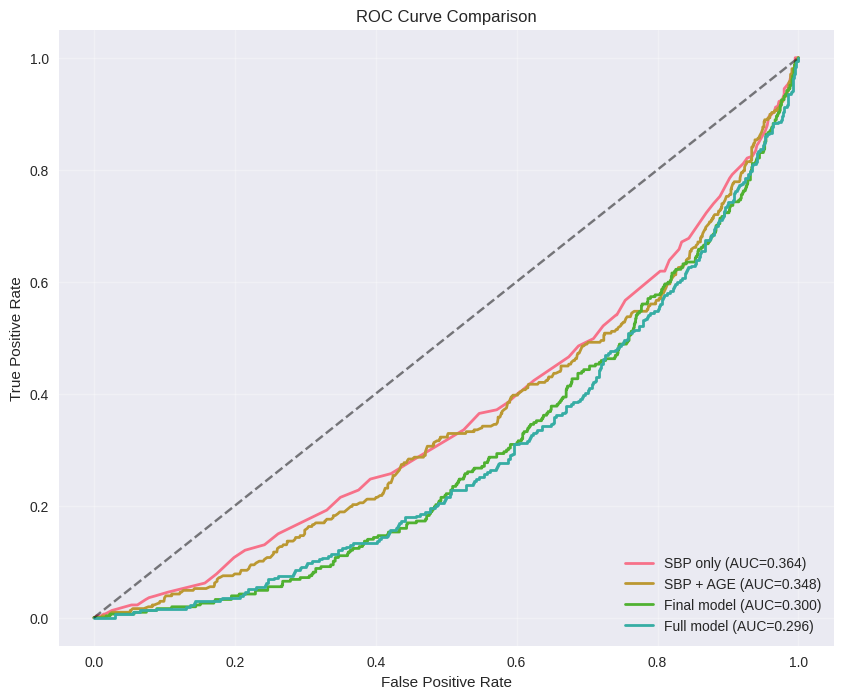

In [56]:
# Calculate ROC curves for multiple models
models_to_compare = {  # dictionary of models
    'SBP only': fit1_result,  # simple model
    'SBP + AGE': fit_2d,  # two predictors
    'Final model': fit_final,  # selected model
    'Full model': fit2_result  # all predictors
}

plt.figure(figsize=(10, 8))  # create figure

for name, model in models_to_compare.items():  # loop through models
    # Get predictions
    probs = model.predict(fram_data_complete)  # predicted probabilities
    # Calculate ROC
    fpr, tpr, _ = roc_curve(fram_data_complete['HD'].astype(int), probs)  # ROC curve
    auc_score = auc(fpr, tpr)  # AUC
    # Plot
    plt.plot(fpr, tpr, linewidth=2,  # plot ROC curve
            label=f'{name} (AUC={auc_score:.3f})')  # label with AUC

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)  # diagonal line
plt.xlabel('False Positive Rate')  # x label
plt.ylabel('True Positive Rate')  # y label
plt.title('ROC Curve Comparison')  # title
plt.legend(loc='lower right')  # legend position
plt.grid(True, alpha=0.3)  # add grid
plt.show()  # display

The `.items()` method returns key-value pairs from a dictionary. Each model's ROC curve shows its discrimination ability. Models with higher AUC (curves closer to the top-left corner) have better overall classification performance. More complex models generally achieve higher AUC but may overfit.

## 6. Bayes Rule with Unequal Losses

When misclassification costs differ, we should adjust our classification threshold.

### 6.1 Bayes' Rule

Define loss functions:
- $L(Y=1, \hat{Y}=0) = a_{1,0}$: cost of false negative (missing disease)
- $L(Y=0, \hat{Y}=1) = a_{0,1}$: cost of false positive (false alarm)

The Bayes optimal rule minimizes expected loss:

$$\hat{Y} = 1 \text{ if } P(Y=1|X) > \frac{a_{0,1}}{a_{0,1} + a_{1,0}}$$

Example: If false negatives are 5 times worse than false positives:

In [57]:
# Define cost ratio
cost_ratio = 5  # a_10 / a_01 (false negative is 5x worse)

# Calculate optimal threshold
bayes_threshold = 1 / (1 + cost_ratio)  # a_01 / (a_01 + a_10)
print(f"Cost ratio (FN/FP): {cost_ratio}")  # display ratio
print(f"Bayes optimal threshold: {bayes_threshold:.3f}")  # display threshold

# Classify using Bayes rule
probs = fit_2d.predict(fram_data_complete)  # get probabilities
y_true = fram_data_complete['HD'].astype(int)  # true labels

# Classification with different thresholds
pred_standard = (probs > 0.5).astype(int)  # standard threshold
pred_bayes = (probs > bayes_threshold).astype(int)  # Bayes threshold

# Calculate weighted misclassification costs
def weighted_cost(y_true, y_pred, cost_fn=5, cost_fp=1):  # function for weighted cost
    """Calculate weighted misclassification cost"""  # docstring
    cm = confusion_matrix(y_true, y_pred)  # confusion matrix
    fn = cm[1, 0]  # false negatives
    fp = cm[0, 1]  # false positives
    return (cost_fn * fn + cost_fp * fp) / len(y_true)  # weighted average cost

cost_standard = weighted_cost(y_true, pred_standard)  # cost with standard threshold
cost_bayes = weighted_cost(y_true, pred_bayes)  # cost with Bayes threshold

print(f"\nWeighted misclassification costs:")  # label
print(f"Standard threshold (0.5): {cost_standard:.3f}")  # standard cost
print(f"Bayes threshold ({bayes_threshold:.3f}): {cost_bayes:.3f}")  # Bayes cost
print(f"Cost reduction: {(cost_standard - cost_bayes)/cost_standard * 100:.1f}%")  # improvement

Cost ratio (FN/FP): 5
Bayes optimal threshold: 0.167

Weighted misclassification costs:
Standard threshold (0.5): 0.817
Bayes threshold (0.167): 0.780
Cost reduction: 4.6%


The Bayes threshold accounts for asymmetric costs. When false negatives are more costly (missing disease is worse than false alarm), we lower the threshold to be more sensitive. The weighted cost function multiplies each error type by its cost before averaging. The Bayes rule minimizes expected loss under the given cost structure.

Visualize the effect of different thresholds:

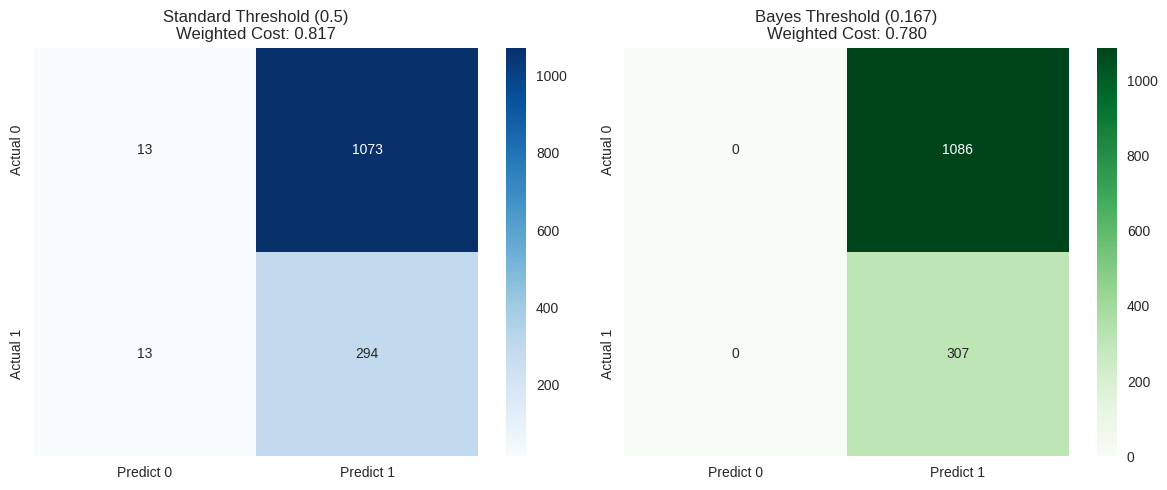

In [58]:
# Compare confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # two subplots

# Standard threshold
cm_standard = confusion_matrix(y_true, pred_standard)  # confusion matrix
sns.heatmap(cm_standard, annot=True, fmt='d', cmap='Blues',  # heatmap
           ax=axes[0],  # first subplot
           xticklabels=['Predict 0', 'Predict 1'],  # x labels
           yticklabels=['Actual 0', 'Actual 1'])  # y labels
axes[0].set_title(f'Standard Threshold (0.5)\nWeighted Cost: {cost_standard:.3f}')  # title

# Bayes threshold
cm_bayes = confusion_matrix(y_true, pred_bayes)  # confusion matrix
sns.heatmap(cm_bayes, annot=True, fmt='d', cmap='Greens',  # heatmap
           ax=axes[1],  # second subplot
           xticklabels=['Predict 0', 'Predict 1'],  # x labels
           yticklabels=['Actual 0', 'Actual 1'])  # y labels
axes[1].set_title(f'Bayes Threshold ({bayes_threshold:.3f})\nWeighted Cost: {cost_bayes:.3f}')  # title

plt.tight_layout()  # adjust spacing
plt.show()  # display

The heatmaps show how the Bayes threshold shifts the balance between false positives and false negatives. With lower threshold, we get more false positives but fewer false negatives, which is optimal when false negatives are more costly.

## 7. Training/Testing Data

To properly evaluate model performance, we split data into training and testing sets:

In [59]:
from sklearn.model_selection import train_test_split  # import splitting function

# Split data: 60% train, 20% test, 20% validation
X = fram_data_complete.drop('HD', axis=1)  # features (all columns except HD)
y = fram_data_complete['HD'].astype(int)  # target variable

# First split: separate training from test+validation
X_train, X_temp, y_train, y_temp = train_test_split(  # split function
    X, y, test_size=0.4, random_state=42, stratify=y)  # 60-40 split

# Second split: separate test from validation
X_test, X_val, y_test, y_val = train_test_split(  # split again
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)  # 50-50 of remaining

print(f"Training set: {len(X_train)} samples")  # training size
print(f"Test set: {len(X_test)} samples")  # test size
print(f"Validation set: {len(X_val)} samples")  # validation size

# Check class balance
print(f"\nClass distribution:")  # label
print(f"Training: {y_train.mean():.3f} positive")  # proportion of HD=1
print(f"Test: {y_test.mean():.3f} positive")  # proportion
print(f"Validation: {y_val.mean():.3f} positive")  # proportion

Training set: 835 samples
Test set: 279 samples
Validation set: 279 samples

Class distribution:
Training: 0.220 positive
Test: 0.222 positive
Validation: 0.219 positive


The `train_test_split()` function randomly splits data. The `test_size=0.4` reserves 40% for testing. The `stratify=y` ensures each split has similar class proportions. The `random_state=42` ensures reproducibility. The `.drop('HD', axis=1)` removes the HD column (axis=1 means columns).

Fit and compare models on training data:

In [60]:
# Create training DataFrame
train_data = pd.concat([X_train, y_train], axis=1)  # combine features and target

# Fit two models on training data
model1_train = smf.glm('HD ~ SBP', data=train_data,  # simple model
                       family=sm.families.Binomial()).fit()  # fit

model2_train = smf.glm('HD ~ SBP + AGE + SEX + CHOL + CIG', data=train_data,  # complex model
                       family=sm.families.Binomial()).fit()  # fit

# Evaluate on test set
test_data = pd.concat([X_test, y_test], axis=1)  # combine test features and target

# Get predictions on test set
prob1_test = model1_train.predict(test_data)  # predictions from model 1
prob2_test = model2_train.predict(test_data)  # predictions from model 2

# Calculate AUC on test set
fpr1, tpr1, _ = roc_curve(y_test, prob1_test)  # ROC for model 1
auc1 = auc(fpr1, tpr1)  # AUC for model 1

fpr2, tpr2, _ = roc_curve(y_test, prob2_test)  # ROC for model 2
auc2 = auc(fpr2, tpr2)  # AUC for model 2

print(f"Test Set Performance:")  # label
print(f"Model 1 (SBP only) - AUC: {auc1:.3f}")  # model 1 AUC
print(f"Model 2 (5 predictors) - AUC: {auc2:.3f}")  # model 2 AUC

# Choose best model based on test performance
best_model = model2_train if auc2 > auc1 else model1_train  # conditional assignment
print(f"\nBest model: {'Model 2' if auc2 > auc1 else 'Model 1'}")  # display choice

Test Set Performance:
Model 1 (SBP only) - AUC: 0.631
Model 2 (5 predictors) - AUC: 0.724

Best model: Model 2


Training data is used to fit models. Test data evaluates and compares models to select the best one. The conditional expression `x if condition else y` returns x if condition is true, otherwise y. Models are compared using test set performance, not training performance, to avoid overfitting bias.

Finally, evaluate the chosen model on validation set:


Validation Set Performance (Final Model):
AUC: 0.685
Accuracy: 0.781

Confusion Matrix:
[[213   5]
 [ 56   5]]


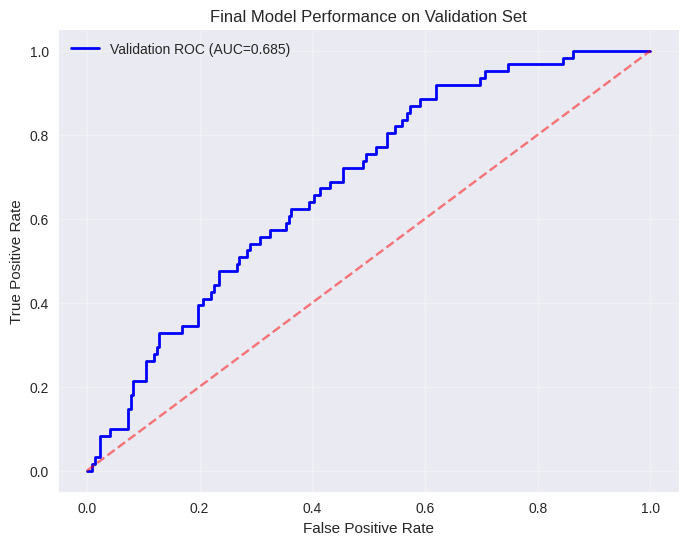

In [61]:
# Final evaluation on validation set
val_data = pd.concat([X_val, y_val], axis=1)  # combine validation data
prob_val = best_model.predict(val_data)  # predictions on validation

# Calculate final performance metrics
fpr_val, tpr_val, _ = roc_curve(y_val, prob_val)  # ROC curve
auc_val = auc(fpr_val, tpr_val)  # AUC

# Classification at 0.5 threshold
pred_val = (prob_val > 0.5).astype(int)  # classify
cm_val = confusion_matrix(y_val, pred_val)  # confusion matrix
accuracy_val = (cm_val[0,0] + cm_val[1,1]) / cm_val.sum()  # accuracy

print(f"\nValidation Set Performance (Final Model):")  # label
print(f"AUC: {auc_val:.3f}")  # AUC
print(f"Accuracy: {accuracy_val:.3f}")  # accuracy
print(f"\nConfusion Matrix:")  # label
print(cm_val)  # display matrix

# Plot final ROC curve
plt.figure(figsize=(8, 6))  # create figure
plt.plot(fpr_val, tpr_val, 'b-', linewidth=2,  # ROC curve
        label=f'Validation ROC (AUC={auc_val:.3f})')  # label
plt.plot([0, 1], [0, 1], 'r--', alpha=0.5)  # diagonal
plt.xlabel('False Positive Rate')  # x label
plt.ylabel('True Positive Rate')  # y label
plt.title('Final Model Performance on Validation Set')  # title
plt.legend()  # show legend
plt.grid(True, alpha=0.3)  # add grid
plt.show()  # display

The validation set provides an unbiased estimate of final model performance. It's kept separate and used only once at the end. This three-way split (train/test/validation) prevents overfitting during both model fitting and model selection. The validation AUC represents expected performance on new, unseen data.

Demonstrate variability across different random splits:

AUC across 10 different splits:
Mean: 0.690
Std Dev: 0.025
Min: 0.657
Max: 0.739


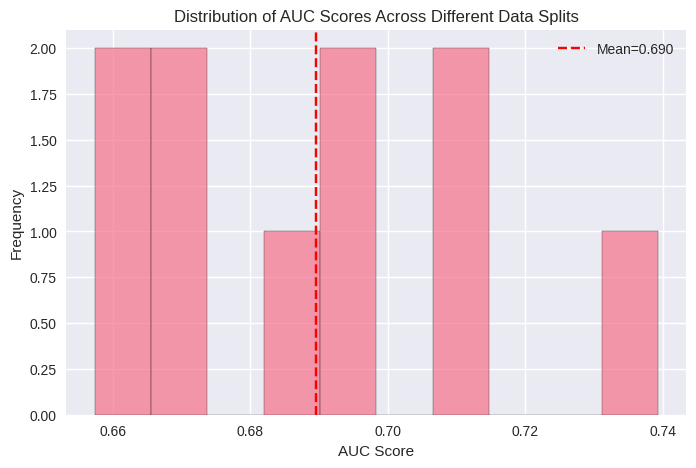

In [62]:
# Show variability with different random splits
auc_scores = []  # list to store AUC values

for seed in range(10):  # try 10 different random splits
    # Split with different seed
    X_tr, X_te, y_tr, y_te = train_test_split(  # split data
        X, y, test_size=0.3, random_state=seed*10, stratify=y)  # different seed

    # Create DataFrames
    train_df = pd.concat([X_tr, y_tr], axis=1)  # training data
    test_df = pd.concat([X_te, y_te], axis=1)  # test data

    # Fit model
    model = smf.glm('HD ~ SBP + AGE + SEX + CHOL', data=train_df,  # fit on training
                   family=sm.families.Binomial()).fit()  # binomial

    # Evaluate
    probs = model.predict(test_df)  # predict on test
    fpr, tpr, _ = roc_curve(y_te, probs)  # ROC curve
    auc_score = auc(fpr, tpr)  # AUC
    auc_scores.append(auc_score)  # store AUC

print(f"AUC across 10 different splits:")  # label
print(f"Mean: {np.mean(auc_scores):.3f}")  # average AUC
print(f"Std Dev: {np.std(auc_scores):.3f}")  # standard deviation
print(f"Min: {np.min(auc_scores):.3f}")  # minimum
print(f"Max: {np.max(auc_scores):.3f}")  # maximum

# Visualize variability
plt.figure(figsize=(8, 5))  # create figure
plt.hist(auc_scores, bins=10, edgecolor='black', alpha=0.7)  # histogram
plt.axvline(x=np.mean(auc_scores), color='r', linestyle='--',  # mean line
           label=f'Mean={np.mean(auc_scores):.3f}')  # label
plt.xlabel('AUC Score')  # x label
plt.ylabel('Frequency')  # y label
plt.title('Distribution of AUC Scores Across Different Data Splits')  # title
plt.legend()  # show legend
plt.show()  # display

Different random splits produce different AUC scores, demonstrating the inherent variability in model evaluation. The `range(10)` creates integers from 0 to 9. Each iteration uses a different `random_state` to create unique splits. The histogram shows the distribution of performance metrics, illustrating why single train-test splits may not be fully reliable. Cross-validation (not shown here) averages over multiple splits for more stable estimates.

## 8. Appendices

### 8.1 Chi-Squared Distribution

The chi-squared distribution is fundamental to likelihood ratio tests in logistic regression:

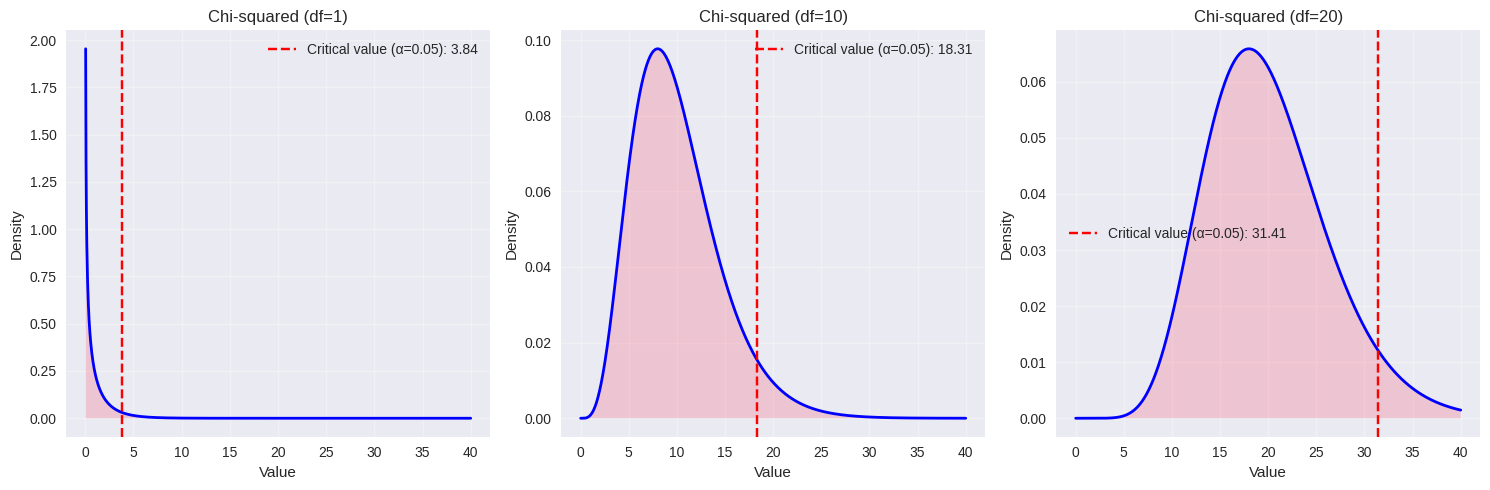

Relationship to normal distribution:
χ²(1) = Z², where Z ~ N(0,1)
χ²(k) = Z₁² + Z₂² + ... + Zₖ², where Zᵢ ~ N(0,1)


In [63]:
# Visualize chi-squared distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # three subplots

# Different degrees of freedom
dfs = [1, 10, 20]  # degrees of freedom to plot

for i, df in enumerate(dfs):  # loop through df values
    x = np.linspace(0, 40, 1000)  # x values
    y = stats.chi2.pdf(x, df)  # probability density function

    axes[i].plot(x, y, 'b-', linewidth=2)  # plot PDF
    axes[i].fill_between(x, y, alpha=0.3)  # fill under curve
    axes[i].set_xlabel('Value')  # x label
    axes[i].set_ylabel('Density')  # y label
    axes[i].set_title(f'Chi-squared (df={df})')  # title
    axes[i].grid(True, alpha=0.3)  # add grid

    # Mark critical value at 0.05 significance
    critical = stats.chi2.ppf(0.95, df)  # 95th percentile
    axes[i].axvline(x=critical, color='r', linestyle='--',  # vertical line
                   label=f'Critical value (α=0.05): {critical:.2f}')  # label
    axes[i].legend()  # show legend

plt.tight_layout()  # adjust spacing
plt.show()  # display

# Relationship to normal distribution
print("Relationship to normal distribution:")  # label
print("χ²(1) = Z², where Z ~ N(0,1)")  # chi-squared with df=1
print("χ²(k) = Z₁² + Z₂² + ... + Zₖ², where Zᵢ ~ N(0,1)")  # general case

The chi-squared distribution with $k$ degrees of freedom equals the sum of $k$ squared standard normal variables. The `stats.chi2.pdf()` computes the probability density function. The `stats.chi2.ppf()` finds percentiles (inverse CDF). As degrees of freedom increase, the distribution becomes more symmetric and approaches normal. The critical value is the threshold for hypothesis testing at a given significance level.